In [398]:
# Isaac Berez
# 17.01.23
import sys
from scipy.io import mmread
import os
import glob
import pandas as pd
import numpy as np
from pandas_ods_reader import read_ods
from copy import deepcopy
import pprint
import json
import re
from datetime import datetime
import logging
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import HuberRegressor
from sklearn import preprocessing
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.cluster import DBSCAN
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from collections import Counter
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
import harmonypy as hm
from matplotlib.cm import ScalarMappable
from datetime import date
import mpld3
import hvplot.pandas
import holoviews as hv
from holoviews import opts
import panel as pn
import bokeh
from bokeh.resources import INLINE

import dimorph_processing as dp
import cell_comparison as cc

today = str(date.today())
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Table of Contents
1. [Introduction](#introduction)
2. [Data Loading](#data_loading)
3. [GABA Analysis](#gaba_analysis)
4. [Vglut1 Analysis](#vglut1_analysis)
5. [Vglut2 Analysis](#vglut2_analysis)
6. [Nonneuronal Analysis](#nn_analysis)

In [2]:
status_df = dp.intialize_status_df()

## Introduction <a name="introduction"></a>

### This notebook compares the amygdala data from Hochgerner et al.  (https://www.nature.com/articles/s41593-023-01469-3) to the sexual dimorphism data analyzed in both "dimorph_processing_nb.ipynb" (level1) and "dimorph_cell_analysis_nb.ipynb" (level2)

In [241]:
IEG_list = []

with open('/bigdata/isaac/IEG_cluster.txt', 'r') as fh:
    for g in fh:
        IEG_list.append(g[:-1])

In [242]:
IEG_list

['Btg2',
 'Jun',
 'Egr4',
 'Fosb',
 'Junb',
 'Gadd45g',
 'Fos',
 'Arc',
 'Nr4a1',
 'Npas4',
 'Coq10b',
 'Tns1',
 'Per2',
 'Ptgs2',
 'Rnd3',
 'Tnfaip6',
 'Srxn1',
 'Tiparp',
 'Ccnl1',
 'Mcl1',
 'Dnajb5',
 'Nr4a3',
 'Fosl2',
 'Nptx2',
 'Rasl11a',
 'Mest',
 'Sertad1',
 'Egr2',
 'Midn',
 'Gadd45b',
 'Dusp6',
 'Irs2',
 'Plat',
 'Ier2',
 'Rrad',
 'Tpbg',
 'Csrnp1',
 'Peli1',
 'Per1',
 'Kdm6b',
 'Inhba',
 'Plk2',
 'Ifrd1',
 'Baz1a',
 'Trib1',
 'Pim3',
 'Lrrk2',
 'Dusp1',
 'Cdkn1a',
 'Pim1',
 'Sik1',
 'Frat2',
 'Dusp5']

### Data Loading - Load data from Hochgerner et al. <a name="data_loading"></a>

In [3]:
amy_df = pd.read_csv('/bigdata/isaac/amy_fc_data/Amy_FC_allcells_with_metadata_31-Jul-2022.txt', encoding='utf-8', delimiter='\t') 

/tmp/ipykernel_1599871/1820059393.py:1: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,2

In [4]:
amy_df.head()

cellID GGGTATTTCTCGCGTT-1_10-1 GGTAACTAGACATCCT-1_18-1  \
0  celltype     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
1    sample                    10-1                    18-1   
2   FC time                       2                       2   
3     batch                       1                       1   
4      Xkr4                       0                       0   

  GGTAATCGTGGACTAG-1_18-1 TTCCGGTAGTGGTGGT-1_18-1 AGGGTGAAGTACAACA-1_19-1  \
0     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
1                    18-1                    18-1                    19-1   
2                       2                       2                       2   
3                       1                       1                       1   
4                       0                       0                       0   

  AGTACCATCCCTGGTT-1_19-1 CATGAGTTCCGGCTTT-1_19-1 TTGCCTGAGACGGTTG-1_19-1  \
0     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
1                    19-1                    19-1                    19-1   
2                       2                       2                       2   
3                       1                       1                       1   
4                       0                       0                       0   

  AAACGCTTCACCATGA-1_23-1  ... TCGAACAAGGAGCTGT-1_76-1  \
0     GABA-11-Adora2a-Id4  ...                     pvm   
1                    23-1  ...                    76-1   
2                       0  ...                       2   
3                       1  ...                       3   
4                       0  ...                       0   

  TGTACAGTCTGCAGCG-1_76-1 AGGACTTTCATGGAGG-1_76-2 CCCATTGGTACCTAGT-1_76-2  \
0                     pvm                     pvm                     pvm   
1                    76-1                    76-2                    76-2   
2                       2                       2                       2   
3                       3                       3                       3   
4                       0                       0                       0   

  CTATCTACAATTGCTG-1_76-2 CTCATCGTCACCCATC-1_76-2 CTGCCATGTATCGCTA-1_76-2  \
0                     pvm                     pvm                     pvm   
1                    76-2                    76-2                    76-2   
2                       2                       2                       2   
3                       3                       3                       3   
4                       0                       0                       0   

  GCATGATTCTCGTCGT-1_76-2 TGGGCGTAGAAGCCAC-1_76-2 TTCTGTAGTGGTATGG-1_76-2  
0                     pvm                     pvm                     pvm  
1                    76-2                    76-2                    76-2  
2                       2                       2                       2  
3                       3                       3                       3  
4                       0                       0                       0  

[5 rows x 55515 columns]

In [5]:
type(amy_df.columns[1])

str

In [6]:
np.array(amy_df.iloc[:,1:2])

array([['GABA-11-Adora2a-Id4'],
       ['10-1'],
       ['2'],
       ...,
       [0],
       [0],
       [0]], dtype=object)

In [7]:
#save as feather for faster loading
#folder = '/bigdata/isaac/amy_fc_data/'
#amy_df = amy_df.astype(str)
#amy_df.to_feather(folder + 'amy_df.feather')

In [8]:
amy_df.columns

Index(['cellID', 'GGGTATTTCTCGCGTT-1_10-1', 'GGTAACTAGACATCCT-1_18-1',
       'GGTAATCGTGGACTAG-1_18-1', 'TTCCGGTAGTGGTGGT-1_18-1',
       'AGGGTGAAGTACAACA-1_19-1', 'AGTACCATCCCTGGTT-1_19-1',
       'CATGAGTTCCGGCTTT-1_19-1', 'TTGCCTGAGACGGTTG-1_19-1',
       'AAACGCTTCACCATGA-1_23-1',
       ...
       'TCGAACAAGGAGCTGT-1_76-1', 'TGTACAGTCTGCAGCG-1_76-1',
       'AGGACTTTCATGGAGG-1_76-2', 'CCCATTGGTACCTAGT-1_76-2',
       'CTATCTACAATTGCTG-1_76-2', 'CTCATCGTCACCCATC-1_76-2',
       'CTGCCATGTATCGCTA-1_76-2', 'GCATGATTCTCGTCGT-1_76-2',
       'TGGGCGTAGAAGCCAC-1_76-2', 'TTCTGTAGTGGTATGG-1_76-2'],
      dtype='object', length=55515)

In [9]:
amy_df = amy_df.set_index('cellID')

In [10]:
amy_df

GGGTATTTCTCGCGTT-1_10-1 GGTAACTAGACATCCT-1_18-1  \
cellID                                                           
celltype           GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                            10-1                    18-1   
FC time                              2                       2   
batch                                1                       1   
Xkr4                                 0                       0   
...                                ...                     ...   
AC168977.1                           0                       0   
PISD                                 9                       0   
DHRSX                                0                       0   
Vmn2r122                             0                       0   
CAAA01147332.1                       0                       0   

               GGTAATCGTGGACTAG-1_18-1 TTCCGGTAGTGGTGGT-1_18-1  \
cellID                                                           
celltype           GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                            18-1                    18-1   
FC time                              2                       2   
batch                                1                       1   
Xkr4                                 0                       0   
...                                ...                     ...   
AC168977.1                           0                       3   
PISD                                 0                       3   
DHRSX                                0                       0   
Vmn2r122                             0                       0   
CAAA01147332.1                       0                       0   

               AGGGTGAAGTACAACA-1_19-1 AGTACCATCCCTGGTT-1_19-1  \
cellID                                                           
celltype           GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                            19-1                    19-1   
FC time                              2                       2   
batch                                1                       1   
Xkr4                                 0                       0   
...                                ...                     ...   
AC168977.1                           0                       0   
PISD                                 8                       0   
DHRSX                                0                       0   
Vmn2r122                             0                       0   
CAAA01147332.1                       0                       0   

               CATGAGTTCCGGCTTT-1_19-1 TTGCCTGAGACGGTTG-1_19-1  \
cellID                                                           
celltype           GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                            19-1                    19-1   
FC time                              2                       2   
batch                                1                       1   
Xkr4                                 0                       0   
...                                ...                     ...   
AC168977.1                           0                       0   
PISD                                 0                       4   
DHRSX                                0                       4   
Vmn2r122                             0                       0   
CAAA01147332.1                       0                       0   

               AAACGCTTCACCATGA-1_23-1 TACCCACCAGTGACCC-1_23-1  ...  \
cellID                                                          ...   
celltype           GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4  ...   
sample                            23-1                    23-1  ...   
FC time                              0                       0  ...   
batch                                1                       1  ...   
Xkr4                                 0                       0  ...   
...                                ...                     ...  ...   
AC168977.1 

In [11]:
amy_df.shape

(28002, 55514)

In [12]:
np.unique(np.array(amy_df.loc['celltype']))

array(['Astro', 'Astro_SC', 'Astro_agt', 'COP', 'EC', 'Epend',
       'GABA-1-Foxp2_Fmod', 'GABA-10-Prkcd-Adora2a',
       'GABA-11-Adora2a-Id4', 'GABA-12-Adora2a-Scn4b',
       'GABA-13-Adora2a-Crh', 'GABA-14-Drd1-Scn4b', 'GABA-15-Drd1-Ebf1',
       'GABA-16-Prkcd-Nts', 'GABA-17-Pdyn-Ebf1', 'GABA-18-Isl1-Tac1',
       'GABA-19-Isl1-Aldoc', 'GABA-2-Foxp2_Adra2a',
       'GABA-20-Gpr101-Gabre', 'GABA-21-Vdr-Nts', 'GABA-22-Gal-Avp',
       'GABA-23-Fign-Lrpprc', 'GABA-24-Fign-Ucn3', 'GABA-25-Lhx8-Th',
       'GABA-26-Cbln4-Sst', 'GABA-27-Lhx6-Nxph2', 'GABA-28-Cbln4-Luzp2',
       'GABA-29-Prlr-Greb1', 'GABA-3-Foxp2_Col6a1', 'GABA-30-Prlr-Calcr',
       'GABA-31-Prlr-Cbln1', 'GABA-32-Prlr-Tac1', 'GABA-33-Prlr-St18',
       'GABA-34-Prlr-Satb1', 'GABA-35-Chodl-Moxd1', 'GABA-36-Sst-Fign',
       'GABA-37-Sst-Npy', 'GABA-38-Sst-Tmtc4', 'GABA-39-Sst-Nek7',
       'GABA-4-Foxp2_Htr1f', 'GABA-40-Rpb4-Sst', 'GABA-41-Moxd1-Pvalb',
       'GABA-42-Moxd1-Vwc2', 'GABA-43-Crabp1-Etv1', 'GABA-44-Pthlh

### seperate out metadata

In [13]:
amy_metadata_df = amy_df.iloc[:4,:]

### add "cell_class" row to metadata

In [14]:
cls = [x.split('-')[0] for x in np.array(amy_metadata_df.loc['celltype'])]

In [244]:
all_cell_classes = list(np.unique(cls))
all_cell_classes

['Astro',
 'Astro_SC',
 'Astro_agt',
 'COP',
 'EC',
 'Epend',
 'GABA',
 'OL',
 'OPC',
 'OPC_cycling',
 'Peri',
 'VGLUT1',
 'VGLUT2',
 'VLMC',
 'VSM',
 'microglia',
 'pvm']

In [16]:
amy_metadata_df.loc['cell_class'] = cls

/tmp/ipykernel_1599871/1827095788.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amy_metadata_df.loc['cell_class'] = cls


In [17]:
#re.split(r"-|_",markers[0][0])[2:4]

In [18]:
markers = [re.split(r"-|_",x)[2:4] for x in np.array(amy_metadata_df.loc['celltype'])]
markers

[['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 'Id4'],
 ['Adora2a', 

In [19]:
amy_metadata_df.loc['markers'] = markers

/tmp/ipykernel_1599871/4262783576.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  amy_metadata_df.loc['markers'] = markers


In [20]:
amy_metadata_df

GGGTATTTCTCGCGTT-1_10-1 GGTAACTAGACATCCT-1_18-1  \
cellID                                                       
celltype       GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                        10-1                    18-1   
FC time                          2                       2   
batch                            1                       1   
cell_class                    GABA                    GABA   
markers             [Adora2a, Id4]          [Adora2a, Id4]   

           GGTAATCGTGGACTAG-1_18-1 TTCCGGTAGTGGTGGT-1_18-1  \
cellID                                                       
celltype       GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                        18-1                    18-1   
FC time                          2                       2   
batch                            1                       1   
cell_class                    GABA                    GABA   
markers             [Adora2a, Id4]          [Adora2a, Id4]   

           AGGGTGAAGTACAACA-1_19-1 AGTACCATCCCTGGTT-1_19-1  \
cellID                                                       
celltype       GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                        19-1                    19-1   
FC time                          2                       2   
batch                            1                       1   
cell_class                    GABA                    GABA   
markers             [Adora2a, Id4]          [Adora2a, Id4]   

           CATGAGTTCCGGCTTT-1_19-1 TTGCCTGAGACGGTTG-1_19-1  \
cellID                                                       
celltype       GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                        19-1                    19-1   
FC time                          2                       2   
batch                            1                       1   
cell_class                    GABA                    GABA   
markers             [Adora2a, Id4]          [Adora2a, Id4]   

           AAACGCTTCACCATGA-1_23-1 TACCCACCAGTGACCC-1_23-1  ...  \
cellID                                                      ...   
celltype       GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4  ...   
sample                        23-1                    23-1  ...   
FC time                          0                       0  ...   
batch                            1                       1  ...   
cell_class                    GABA                    GABA  ...   
markers             [Adora2a, Id4]          [Adora2a, Id4]  ...   

           TCGAACAAGGAGCTGT-1_76-1 TGTACAGTCTGCAGCG-1_76-1  \
cellID                                                       
celltype                       pvm                     pvm   
sample                        76-1                    76-1   
FC time                          2                       2   
batch                            3                       3   
cell_class                     pvm                     pvm   
markers                         []                      []   

           AGGACTTTCATGGAGG-1_76-2 CCCATTGGTACCTAGT-1_76-2  \
cellID                                                       
celltype                       pvm                     pvm   
sample                        76-2                    76-2   
FC time                          2                       2   
batch                            3                       3   
cell_class                     pvm                     pvm   
markers                         []                      []   

           CTATCTACAATTGCTG-1_76-2 CTCATCGTCACCCATC-1_76-2  \
cellID                                                       
celltype                       pvm                     pvm   
sample                        76-2                    76-2   
FC time                          2                       2   
batch                            3                       3   
cell_class                     pvm                     pvm   
markers                         []                      []

### cell classes of interest: GABA, Vglut1, Vglut2, NN = microglia + epend + astro

In [21]:
amy_df.head()

GGGTATTTCTCGCGTT-1_10-1 GGTAACTAGACATCCT-1_18-1  \
cellID                                                     
celltype     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                      10-1                    18-1   
FC time                        2                       2   
batch                          1                       1   
Xkr4                           0                       0   

         GGTAATCGTGGACTAG-1_18-1 TTCCGGTAGTGGTGGT-1_18-1  \
cellID                                                     
celltype     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                      18-1                    18-1   
FC time                        2                       2   
batch                          1                       1   
Xkr4                           0                       0   

         AGGGTGAAGTACAACA-1_19-1 AGTACCATCCCTGGTT-1_19-1  \
cellID                                                     
celltype     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                      19-1                    19-1   
FC time                        2                       2   
batch                          1                       1   
Xkr4                           0                       0   

         CATGAGTTCCGGCTTT-1_19-1 TTGCCTGAGACGGTTG-1_19-1  \
cellID                                                     
celltype     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                      19-1                    19-1   
FC time                        2                       2   
batch                          1                       1   
Xkr4                           0                       0   

         AAACGCTTCACCATGA-1_23-1 TACCCACCAGTGACCC-1_23-1  ...  \
cellID                                                    ...   
celltype     GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4  ...   
sample                      23-1                    23-1  ...   
FC time                        0                       0  ...   
batch                          1                       1  ...   
Xkr4                           0                       0  ...   

         TCGAACAAGGAGCTGT-1_76-1 TGTACAGTCTGCAGCG-1_76-1  \
cellID                                                     
celltype                     pvm                     pvm   
sample                      76-1                    76-1   
FC time                        2                       2   
batch                          3                       3   
Xkr4                           0                       0   

         AGGACTTTCATGGAGG-1_76-2 CCCATTGGTACCTAGT-1_76-2  \
cellID                                                     
celltype                     pvm                     pvm   
sample                      76-2                    76-2   
FC time                        2                       2   
batch                          3                       3   
Xkr4                           0                       0   

         CTATCTACAATTGCTG-1_76-2 CTCATCGTCACCCATC-1_76-2  \
cellID                                                     
celltype                     pvm                     pvm   
sample                      76-2                    76-2   
FC time                        2                       2   
batch                          3                       3   
Xkr4                           0                       0   

         CTGCCATGTATCGCTA-1_76-2 GCATGATTCTCGTCGT-1_76-2  \
cellID                                                     
celltype                     pvm                     pvm   
sample                      76-2                    76-2   
FC time                        2                       2   
batch                          3                       3   
Xkr4                           0                       0   

         TGGGCGTAGAAGCCAC-1_76-2 TTCTGTAGTGGTATGG-1_76-2  
cellID                                                    
celltype                     pvm                     pvm  
sample  

In [22]:
amy_df.loc['celltype'].index

Index(['GGGTATTTCTCGCGTT-1_10-1', 'GGTAACTAGACATCCT-1_18-1',
       'GGTAATCGTGGACTAG-1_18-1', 'TTCCGGTAGTGGTGGT-1_18-1',
       'AGGGTGAAGTACAACA-1_19-1', 'AGTACCATCCCTGGTT-1_19-1',
       'CATGAGTTCCGGCTTT-1_19-1', 'TTGCCTGAGACGGTTG-1_19-1',
       'AAACGCTTCACCATGA-1_23-1', 'TACCCACCAGTGACCC-1_23-1',
       ...
       'TCGAACAAGGAGCTGT-1_76-1', 'TGTACAGTCTGCAGCG-1_76-1',
       'AGGACTTTCATGGAGG-1_76-2', 'CCCATTGGTACCTAGT-1_76-2',
       'CTATCTACAATTGCTG-1_76-2', 'CTCATCGTCACCCATC-1_76-2',
       'CTGCCATGTATCGCTA-1_76-2', 'GCATGATTCTCGTCGT-1_76-2',
       'TGGGCGTAGAAGCCAC-1_76-2', 'TTCTGTAGTGGTATGG-1_76-2'],
      dtype='object', length=55514)

## GABA Analysis <a name="gaba_analysis"></a>

removing # duplicate gene rows:  65
removing  53  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']
Total genes reduced from 27880 to 14303


<IPython.core.display.Javascript object>


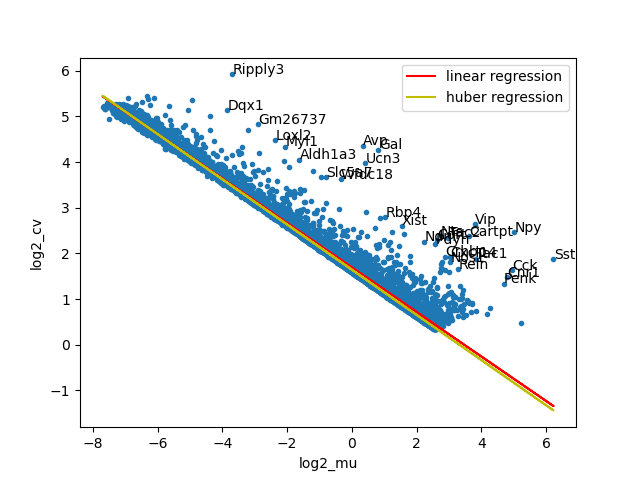

<IPython.core.display.Javascript object>


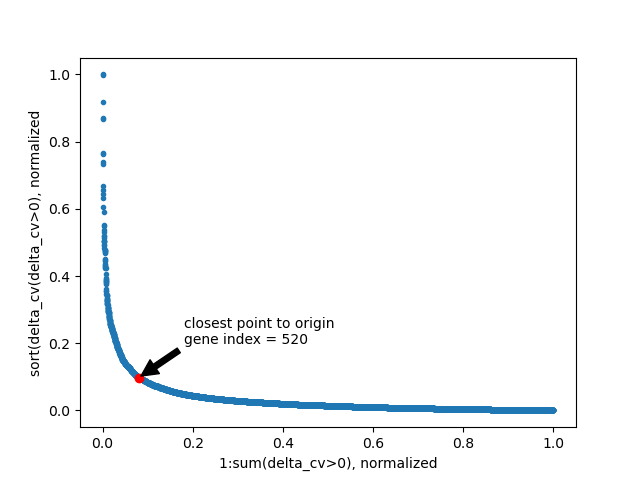

column (gene) mean after standardization: -0.00
column (gene) sigma after standardization: 1.00


In [237]:
amy_df_gaba_expr_ge_cv_ls, amy_metadata_df_gaba = cc.process_amy_data_class(amy_df,amy_metadata_df,IEG_list,cell_class='GABA')

In [238]:
amy_df_gaba_expr_ge_cv_ls.shape

(520, 13006)

In [34]:
amy_df_gaba_expr_ge_cv_ls

GGGTATTTCTCGCGTT-1_10-1  GGTAACTAGACATCCT-1_18-1  \
cellID                                                     
Sst                   -0.545385                 0.306249   
Npy                    1.105514                -0.442248   
Gal                   -0.112651                -0.112651   
Avp                   -0.108845                -0.108845   
Vip                   -0.222700                -0.222700   
...                         ...                      ...   
Mdfic                 -0.047916                -0.047916   
Pld5                  -0.429433                -0.429433   
Kcnip4                -0.813752                 1.404627   
Tppp3                 -0.539772                -0.539772   
Lhfp                  -0.166229                -0.166229   

        GGTAATCGTGGACTAG-1_18-1  TTCCGGTAGTGGTGGT-1_18-1  \
cellID                                                     
Sst                   -0.545385                -0.545385   
Npy                   -0.442248                -0.442248   
Gal                   -0.112651                -0.112651   
Avp                   -0.108845                -0.108845   
Vip                   -0.222700                -0.222700   
...                         ...                      ...   
Mdfic                 -0.047916                -0.047916   
Pld5                  -0.429433                -0.429433   
Kcnip4                -0.813752                -0.813752   
Tppp3                 -0.539772                 1.656778   
Lhfp                  -0.166229                -0.166229   

        AGGGTGAAGTACAACA-1_19-1  AGTACCATCCCTGGTT-1_19-1  \
cellID                                                     
Sst                   -0.545385                -0.545385   
Npy                   -0.442248                -0.442248   
Gal                   -0.112651                -0.112651   
Avp                   -0.108845                -0.108845   
Vip                   -0.222700                -0.222700   
...                         ...                      ...   
Mdfic                 -0.047916                -0.047916   
Pld5                  -0.429433                -0.429433   
Kcnip4                -0.813752                 1.178894   
Tppp3                 -0.539772                -0.539772   
Lhfp                  -0.166229                -0.166229   

        CATGAGTTCCGGCTTT-1_19-1  TTGCCTGAGACGGTTG-1_19-1  \
cellID                                                     
Sst                   -0.545385                 1.157884   
Npy                   -0.442248                -0.442248   
Gal                   -0.112651                -0.112651   
Avp                   -0.108845                -0.108845   
Vip                   -0.222700                -0.222700   
...                         ...                      ...   
Mdfic                 -0.047916                -0.047916   
Pld5                   2.052045                -0.429433   
Kcnip4                -0.813752                -0.813752   
Tppp3                  1.656778                -0.539772   
Lhfp                   6.210554                -0.166229   

        AAACGCTTCACCATGA-1_23-1  TACCCACCAGTGACCC-1_23-1  ...  \
cellID                                                    ...   
Sst                   -0.545385                 0.443332  ...   
Npy                   -0.442248                -0.442248  ...   
Gal                   -0.112651                -0.112651  ...   
Avp                   -0.108845                -0.108845  ...   
Vip                   -0.222700                -0.222700  ...   
...                         ...                      ...  ...   
Mdfic                 -0.047916                -0.047916  ...   
Pld5                  -0.429433                -0.429433  ...   
Kcnip4                 1.178894                 1.178894  ...   
Tppp3                  2.941677                -0.539772  ...   
Lhfp                  -0.166229                -0.166229  ...   

        GTCAAACTCCCGATCT-1_76-2  GTGTA

In [239]:
amy_metadata_df_gaba.shape

(7, 13006)

In [33]:
amy_metadata_df_gaba

GGGTATTTCTCGCGTT-1_10-1 GGTAACTAGACATCCT-1_18-1  \
cellID                                                          
celltype          GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                           10-1                    18-1   
FC time                             2                       2   
batch                               1                       1   
cell_class                       GABA                    GABA   
markers                [Adora2a, Id4]          [Adora2a, Id4]   
cluster_label                      11                      11   

              GGTAATCGTGGACTAG-1_18-1 TTCCGGTAGTGGTGGT-1_18-1  \
cellID                                                          
celltype          GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                           18-1                    18-1   
FC time                             2                       2   
batch                               1                       1   
cell_class                       GABA                    GABA   
markers                [Adora2a, Id4]          [Adora2a, Id4]   
cluster_label                      11                      11   

              AGGGTGAAGTACAACA-1_19-1 AGTACCATCCCTGGTT-1_19-1  \
cellID                                                          
celltype          GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                           19-1                    19-1   
FC time                             2                       2   
batch                               1                       1   
cell_class                       GABA                    GABA   
markers                [Adora2a, Id4]          [Adora2a, Id4]   
cluster_label                      11                      11   

              CATGAGTTCCGGCTTT-1_19-1 TTGCCTGAGACGGTTG-1_19-1  \
cellID                                                          
celltype          GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4   
sample                           19-1                    19-1   
FC time                             2                       2   
batch                               1                       1   
cell_class                       GABA                    GABA   
markers                [Adora2a, Id4]          [Adora2a, Id4]   
cluster_label                      11                      11   

              AAACGCTTCACCATGA-1_23-1 TACCCACCAGTGACCC-1_23-1  ...  \
cellID                                                         ...   
celltype          GABA-11-Adora2a-Id4     GABA-11-Adora2a-Id4  ...   
sample                           23-1                    23-1  ...   
FC time                             0                       0  ...   
batch                               1                       1  ...   
cell_class                       GABA                    GABA  ...   
markers                [Adora2a, Id4]          [Adora2a, Id4]  ...   
cluster_label                      11                      11  ...   

              GTCAAACTCCCGATCT-1_76-2 GTGTAACGTGAGACCA-1_76-2  \
cellID                                                          
celltype              GABA-51-Vip-Crh         GABA-51-Vip-Crh   
sample                           76-2                    76-2   
FC time                             2                       2   
batch                               2                       2   
cell_class                       GABA                    GABA   
markers                    [Vip, Crh]              [Vip, Crh]   
cluster_label                      51                      51   

              GTGTGATAGGTGAGAA-1_76-2 TACTTCAGTAACTAAG-1_76-2  \
cellID                                                          
celltype              GABA-51-Vip-Crh         GABA-51-Vip-Crh   
sample                           76-2                    76-2   
FC time                             2                       2   
batch                               2                       2   
cell_class                       GABA                    GABA  

In [ ]:
#save to file

#folder = '/bigdata/isaac/gaba_files/'

#file1 = 'amy_df_gaba_expr_ge_cv_ls_orig' 
#file2 = 'amy_metadata_df_gaba_orig' 

#amy_df_gaba_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_gaba.to_json(folder+file2+'.json')

In [103]:
folder = '/bigdata/isaac/gaba_files/'

In [86]:
amy_df_gaba_expr_ge_cv_ls_orig = pd.read_feather(folder + 'amy_df_gaba_expr_ge_cv_ls_orig.feather')
amy_metadata_df_gaba_orig = pd.read_json(folder + 'amy_metadata_df_gaba_orig.json')

### Load gaba_df_prelinkage_ls saved from "dimorph_cell_analysis_nb.ipynb" and get intersection
### already has feature selected genes

In [37]:
#gaba_df_marker = pd.read_feather('/bigdata/isaac/gaba_files/gaba_df_marker_2024-06-07.feather')
gaba_meta_data_df_plis = pd.read_json('/bigdata/isaac/gaba_files/gaba_meta_data_df_plis2024-06-07.json')

gaba_df_prelinkage_ls_orig = pd.read_feather('/bigdata/isaac/gaba_files/gaba_df_pre_linkage_ls_2024-06-04.feather')
gaba_metadata_df_prelinkage_ls_orig = pd.read_json('/bigdata/isaac/gaba_files/gaba_meta_data_df_pre_linkage_2024-06-04.json')


In [68]:
lco = pd.unique(gaba_meta_data_df_plis.loc['cluster_label'])
lco

array([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38, 2, 20, 35, 0, 14,
       4, 5, 3, 15, 11, 10, 6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28, 8,
       7, 19, 17, 44, 46, 45, 9, 47, 50, 23, 1, 13, 29, 30, 32, 56, 51,
       57, 53, 48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype=object)

In [107]:
pd.unique(gaba_metadata_df_prelinkage_ls_orig.loc['cluster_label'])

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=object)

In [253]:
amy_df_gaba_expr_ge_cv_ls, gaba_df_prelinkage_ls = cc.get_df_gene_intersection(gaba_df_prelinkage_ls_orig,amy_df_gaba_expr_ge_cv_ls,IEG_list)

removing  0  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']
Index(['Sst', 'Npy', 'Gal', 'Avp', 'Vip', 'Ucn3', 'Cartpt', 'Ripply3', 'Cck',
       'Cnr1',
       ...
       'Nbl1', 'Jsrp1', 'Sostdc1', 'Shisa6', 'Fam19a2', 'Pdlim5', 'Ppargc1a',
       'Pld5', 'Kcnip4', 'Lhfp'],
      dtype='object', length=378)


In [254]:
amy_df_gaba_expr_ge_cv_ls.shape

(378, 13006)

In [255]:
gaba_df_prelinkage_ls.shape

(378, 13529)

### Checkpoint - save intersected data/metadata to file / load from here

In [119]:
folder

'/bigdata/isaac/gaba_files/'

In [ ]:
#save to file

#folder = '/bigdata/isaac/gaba_files/'

#file1 = 'amy_df_gaba_expr_ge_cv_ls_cell_comp' 
#file2 = 'amy_metadata_df_gaba_cell_comp' 

#amy_df_gaba_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_gaba.to_json(folder+file2+'.json')

#################################

#file1 = 'gaba_df_prelinkage_ls_cell_comp' 
#file2 = 'gaba_meta_data_df_prelinkage_cell_comp' 

#gaba_df_prelinkage_ls.to_feather(folder+file1+'.feather')
#gaba_meta_data_df_pre_linkage.to_json(folder+file2+'.json')


In [52]:
#load data
folder = '/bigdata/isaac/gaba_files/'

amy_df_gaba_expr_ge_cv_ls = pd.read_feather(folder + 'amy_df_gaba_expr_ge_cv_ls_cell_comp.feather')
amy_metadata_df_gaba = pd.read_json(folder + 'amy_metadata_df_gaba_cell_comp.json')

gaba_df_prelinkage_ls = pd.read_feather(folder + 'gaba_df_prelinkage_ls_cell_comp.feather')
gaba_meta_data_df_prelinkage = pd.read_json(folder + 'gaba_meta_data_df_prelinkage_cell_comp.json' )

### Compute avg expression for all genes, for every cluster

In [48]:
amy_avgs = dp.compute_avg_expr_per_cluster_label(amy_df_gaba_expr_ge_cv_ls,amy_metadata_df_gaba)

In [122]:
amy_avgs

1         2         3         4         5         6   \
Sst      -0.155349 -0.280595 -0.455989 -0.492804 -0.148882 -0.314029   
Npy      -0.359158  -0.22505  0.068509  0.900939 -0.086038 -0.150077   
Gal      -0.112651 -0.112651 -0.089581 -0.112651 -0.074812 -0.069099   
Avp      -0.108845 -0.071297 -0.028345 -0.108845 -0.052378 -0.021984   
Vip      -0.211028  -0.20211 -0.196752 -0.158658 -0.172872 -0.205202   
...            ...       ...       ...       ...       ...       ...   
Pdlim5   -0.213751  0.238679 -0.262204 -0.221797 -0.258688 -0.112715   
Ppargc1a  0.367969 -0.343563 -0.508327  -0.56609 -0.381029 -0.377084   
Pld5       0.36542  0.951358 -0.240701 -0.005046  0.487558  0.130078   
Kcnip4    0.535392  0.517315  0.247973  0.685572  0.714297  0.258686   
Lhfp     -0.107726 -0.149704 -0.015354 -0.075132 -0.110292 -0.107323   

                7         8         9         10  ...        47        48  \
Sst       0.423542 -0.263417 -0.395131 -0.501013  ...  0.155029 -0.447587   
Npy       -0.38883 -0.387799 -0.364963 -0.282428  ... -0.333043 -0.372397   
Gal      -0.112651 -0.087391 -0.068467 -0.112651  ... -0.097408 -0.105911   
Avp      -0.073287 -0.055146  -0.05929 -0.052248  ... -0.086099 -0.053048   
Vip      -0.204007  -0.19946 -0.199775 -0.193786  ... -0.172384 -0.192407   
...            ...       ...       ...       ...  ...       ...       ...   
Pdlim5   -0.231641 -0.040965  0.636983 -0.275033  ... -0.089209 -0.245919   
Ppargc1a -0.113144 -0.000711  0.085683  0.054693  ...   0.26656  0.462964   
Pld5       0.07014 -0.385895 -0.406659 -0.206469  ... -0.077231 -0.328914   
Kcnip4   -0.060652 -0.047448  0.049714  0.321894  ... -0.681736  0.666536   
Lhfp     -0.166229 -0.150522 -0.122178 -0.051377  ... -0.081822  0.020414   

                49        50        51        52        53        54  \
Sst      -0.450272 -0.514228 -0.427441 -0.440583 -0.451893 -0.427688   
Npy      -0.366435 -0.401907 -0.352834 -0.374402 -0.396366 -0.403158   
Gal      -0.050846  0.248763 -0.100601 -0.041433 -0.112651 -0.112651   
Avp       0.014219  0.012632  0.005873 -0.026616  -0.08045 -0.026667   
Vip      -0.048683   2.22628  4.872482   -0.2227 -0.116881  0.244626   
...            ...       ...       ...       ...       ...       ...   
Pdlim5   -0.256575 -0.021224  0.016749 -0.197397 -0.220275  -0.12304   
Ppargc1a  0.207191 -0.251954 -0.049666 -0.366242 -0.364607 -0.226413   
Pld5      0.729462  0.605465 -0.204186 -0.336766 -0.136654 -0.280694   
Kcnip4    0.522226 -0.083875  0.150193 -0.050973 -0.617036  0.345685   
Lhfp     -0.080104  0.418846   -0.1343 -0.166229 -0.047641 -0.082517   

                55        56  
Sst      -0.345629 -0.444237  
Npy      -0.264757 -0.154209  
Gal      -0.112651   -0.0807  
Avp      -0.108845 -0.067684  
Vip       3.712796    -0.111  
...            ...       ...  
Pdlim5   -0.148883  0.892313  
Ppargc1a -0.300026  -0.28419  
Pld5     -0.142431 -0.358911  
Kcnip4    0.713779 -0.487957  
Lhfp     -0.106776  0.000309  

[378 rows x 56 columns]

In [53]:
sd_avgs = dp.compute_avg_expr_per_cluster_label(gaba_df_prelinkage_ls,gaba_meta_data_df_prelinkage)

In [124]:
sd_avgs

0         1         2         3         4         5   \
Sst      -0.052799 -0.335815 -0.350333 -0.355693 -0.383913 -0.355985   
Npy      -0.283375 -0.266134 -0.274041 -0.277158 -0.251861 -0.277019   
Gal      -0.126186 -0.074353  0.206326 -0.121254 -0.126186 -0.126186   
Avp       0.125462 -0.006238 -0.049596  0.012925 -0.072924  0.011349   
Vip      -0.140506 -0.154338 -0.154338 -0.141714 -0.154338 -0.146863   
...            ...       ...       ...       ...       ...       ...   
Pdlim5    -0.11998 -0.189726 -0.149567  -0.18336 -0.089394  -0.17088   
Ppargc1a  0.235094  0.649442 -0.308002   0.18521 -0.250753 -0.095112   
Pld5     -0.278213 -0.290832 -0.170091 -0.381998  0.077507  0.216949   
Kcnip4    0.348098 -0.235703 -0.318286  0.679367 -0.318462  0.103619   
Lhfp     -0.061433  0.611826  0.339463 -0.119438 -0.200898 -0.038214   

                6         7         8         9   ...        56        57  \
Sst      -0.340964  -0.19556 -0.265766 -0.236357  ... -0.345609 -0.358898   
Npy      -0.264008 -0.249343 -0.260414 -0.258252  ... -0.254232 -0.279362   
Gal      -0.115208 -0.086827 -0.126186 -0.037761  ... -0.126186 -0.126186   
Avp       0.023045 -0.097437  0.052388   0.03684  ... -0.093788  0.046217   
Vip      -0.148718 -0.143694 -0.148833 -0.150188  ...  6.180234  0.292554   
...            ...       ...       ...       ...  ...       ...       ...   
Pdlim5   -0.161391 -0.155866 -0.056705 -0.147878  ...  0.067439   0.64145   
Ppargc1a  -0.21442 -0.241566 -0.379606  0.034571  ... -0.370182 -0.106719   
Pld5      0.506481  0.246273  0.035793 -0.234992  ... -0.230746 -0.386371   
Kcnip4    0.194134  0.035256  0.159885   0.24254  ... -0.105421 -0.326052   
Lhfp     -0.178235 -0.152353 -0.116703  0.070704  ... -0.177504 -0.133191   

                58        59        60        61        62        63  \
Sst      -0.361009 -0.373029  0.168473  -0.35041  3.078125  -0.03385   
Npy      -0.083082  0.189093  0.126427 -0.287002  3.211631  0.065238   
Gal      -0.126186 -0.126186 -0.105983 -0.126186 -0.091943 -0.126186   
Avp      -0.201913  -0.02162 -0.085422 -0.071679 -0.099653 -0.047967   
Vip      -0.128649 -0.138424 -0.143997 -0.154338 -0.148495 -0.154338   
...            ...       ...       ...       ...       ...       ...   
Pdlim5    1.137411  2.250012 -0.150619 -0.161587 -0.160266 -0.145376   
Ppargc1a -0.106876 -0.580984  1.162206  1.274981   0.27052  0.336414   
Pld5      0.332568  0.861317 -0.348903  -0.39976 -0.222383 -0.267581   
Kcnip4   -0.788783 -0.521333 -0.664137 -0.800358 -0.669239 -0.630478   
Lhfp     -0.149097 -0.174738  0.073733  0.181716 -0.123317  -0.15505   

                64        65  
Sst       3.957141  1.575562  
Npy       3.251905  1.751706  
Gal      -0.126186 -0.126186  
Avp      -0.201913   0.04019  
Vip      -0.154338 -0.154338  
...            ...       ...  
Pdlim5    0.050282 -0.189726  
Ppargc1a  0.719777 -0.197765  
Pld5     -0.313061 -0.352265  
Kcnip4    0.099243 -0.284288  
Lhfp     -0.200898 -0.200898  

[378 rows x 66 columns]

In [125]:
sd_avgs.columns

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
       54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65],
      dtype='object')

In [126]:
np.unique(np.array(gaba_meta_data_df_prelinkage.loc['cluster_label']))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65], dtype=object)

### Compute pearson correlation coeffcient for every column between avg expr datasets

corr_matrix_manual = dim(sd_avgs x amy_avgs)

In [56]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual = pd.DataFrame(index=sd_avgs.columns, columns=amy_avgs.columns)

# Compute the correlation coefficients
for col1 in sd_avgs.columns:
    for col2 in amy_avgs.columns:
        corr_matrix_manual.loc[col1, col2] = sd_avgs[col1].corr(amy_avgs[col2])

In [57]:
corr_matrix_manual.shape

(66, 56)

In [129]:
corr_matrix_manual

1         2         3         4         5         6         7   \
0   -0.01201  0.020433   0.06362  -0.02082  0.000904  0.027228  0.034012   
1    0.08766 -0.039294 -0.034626 -0.013889 -0.004004 -0.069779  0.044852   
2   0.084488  0.032233  0.093602  0.166215  0.187083  0.114193  0.165848   
3   0.175915   0.19637  0.155996  0.099051  0.128262  0.006573  0.079272   
4   0.051464  0.081996  0.149322   0.24157   0.41849  0.237807   0.35341   
..       ...       ...       ...       ...       ...       ...       ...   
61 -0.104907 -0.137763 -0.173484 -0.163342 -0.263405 -0.211678 -0.229007   
62 -0.101302 -0.171687 -0.226034 -0.195269 -0.288026 -0.229857 -0.188199   
63 -0.059025 -0.187182 -0.280098 -0.283435 -0.349985 -0.302309 -0.282447   
64 -0.054707 -0.126893 -0.159199 -0.112919 -0.173601 -0.170755 -0.109088   
65 -0.043558 -0.105922 -0.108965 -0.108461 -0.175166 -0.182968 -0.097166   

          8         9         10  ...        47        48        49        50  \
0   -0.06181  0.142248  0.164479  ...   0.04024  0.159923 -0.092633 -0.031112   
1   0.064597   -0.0973 -0.034907  ...  0.047653  0.152267  0.005393 -0.017404   
2   0.172464  0.054936  0.028032  ... -0.245826 -0.215955  -0.11534 -0.009132   
3   0.061207  0.151743  0.176193  ... -0.003676  0.629394  0.083292 -0.046276   
4   0.281377  0.224841  0.186672  ... -0.165283   0.03575  0.024819 -0.019976   
..       ...       ...       ...  ...       ...       ...       ...       ...   
61 -0.167774 -0.131576 -0.111821  ...  0.087417 -0.072357 -0.092484 -0.013462   
62 -0.187155 -0.162989 -0.174742  ...  0.128739 -0.094751 -0.073041 -0.059805   
63 -0.196692 -0.133033  -0.16159  ...  0.095116 -0.058105   0.02356 -0.018006   
64 -0.101524 -0.132849  -0.13749  ...  0.054623 -0.073408  0.016512 -0.063889   
65 -0.012585 -0.002416 -0.040313  ... -0.058263 -0.022981 -0.017018 -0.043647   

          51        52        53        54        55        56  
0  -0.052816 -0.112296 -0.084936 -0.113639 -0.106715 -0.086127  
1  -0.110333  -0.10663 -0.077786 -0.035559  -0.04132  0.005037  
2  -0.198511 -0.267668 -0.196831 -0.220429 -0.166209 -0.118693  
3  -0.101233  -0.02545 -0.022972 -0.059853 -0.065599 -0.082605  
4  -0.117015 -0.139005 -0.126627 -0.155594 -0.149778 -0.129659  
..       ...       ...       ...       ...       ...       ...  
61  0.050144 -0.028618   0.00802  0.012118  0.033511   0.04108  
62  0.006234 -0.014712  0.033338 -0.026364 -0.054414 -0.021657  
63  0.086695  0.090782   0.01142 -0.000663 -0.017045 -0.025021  
64 -0.094688 -0.053171 -0.042992 -0.081869 -0.065134 -0.043778  
65  0.020059  0.033946 -0.021316 -0.095032  -0.07366 -0.162091  

[66 rows x 56 columns]

In [59]:
# Calculate the 2nd and 98th percentiles for robust scaling (mimicing seaborn's robust = TRUE)
#vmin, vmax = np.percentile(corr_matrix_manual.values, [2, 98])

# Create the heatmap
heatmap = corr_matrix_manual.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:44235


:HeatMap   [columns,index]   (value)

In [60]:
#take argmax of every row of corr_matrix_manual, store in seperate dataframe, then resort corr_matrix_manual rows by ascending arg_max values
heatmap_argmax_df = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual.index)
for i in corr_matrix_manual.index:
    heatmap_argmax_df.iloc[i,:] = (np.argmax(corr_matrix_manual.loc[i,:]),np.max(corr_matrix_manual.loc[i,:]))
heatmap_argmax_df.sort_values(by = 'argmax')
corr_matrix_manual_sorted = corr_matrix_manual.reindex(index = heatmap_argmax_df.sort_values(by = 'argmax').index)

In [132]:
corr_matrix_manual_sorted.index

Index([17, 19, 44,  4,  6, 25, 18,  8, 46, 22, 28, 26, 15, 14,  0, 24, 11,  7,
       10, 30, 45, 27, 32, 34, 23,  1, 35, 47, 29, 50, 13,  5, 20,  2, 38,  9,
       16, 39, 43, 12, 40, 42, 55, 65, 33, 36, 54, 64, 52, 62, 60, 63, 61, 58,
       59, 53,  3, 49, 48, 37, 41, 21, 31, 56, 51, 57],
      dtype='object')

In [133]:
corr_matrix_manual_sorted

1         2         3         4         5         6         7   \
17  0.454419  0.832672  0.803021  0.748034  0.371633  0.192474  0.187261   
19  0.150352  0.167306  0.347238  0.241095  0.191112  0.201605  0.111167   
44  0.129356  0.177138  0.384141  0.312789   0.27007  0.314081  0.122117   
4   0.051464  0.081996  0.149322   0.24157   0.41849  0.237807   0.35341   
6   0.039921  0.135038  0.224698  0.279188  0.365738  0.263527  0.243114   
..       ...       ...       ...       ...       ...       ...       ...   
21  0.059859  0.109444  0.074455  0.112215  0.200794  0.094597  0.216131   
31  0.004663 -0.001427 -0.015587 -0.019255  0.010691  0.091802   0.02666   
56 -0.130521 -0.164516 -0.170299 -0.204525 -0.200786 -0.255927 -0.215673   
51 -0.035846 -0.100492 -0.126225 -0.175526 -0.225366 -0.277157 -0.240271   
57 -0.091128 -0.163251 -0.230491 -0.254378 -0.269656 -0.259885 -0.253261   

          8         9         10  ...        47        48        49        50  \
17  0.080278  0.105659   0.17905  ... -0.163907 -0.114661 -0.113758 -0.077285   
19  0.102905  0.084646  0.141948  ... -0.192649 -0.118739 -0.019246  0.021432   
44  0.097171  0.099063  0.219512  ... -0.176532 -0.165148 -0.123377  0.017607   
4   0.281377  0.224841  0.186672  ... -0.165283   0.03575  0.024819 -0.019976   
6   0.146278  0.043015  0.104321  ... -0.153249 -0.073177  0.181785 -0.009951   
..       ...       ...       ...  ...       ...       ...       ...       ...   
21   0.10002 -0.099584  -0.06769  ...  0.060636  0.206905  0.606596  0.029971   
31  0.024942  0.001592 -0.014212  ... -0.046535 -0.029529 -0.024156  0.887527   
56 -0.112106 -0.093364 -0.102917  ...  0.148411 -0.040106  0.177473  0.215484   
51 -0.176025 -0.164085 -0.177361  ...  0.372539  0.085133  0.175069  0.117657   
57 -0.192884 -0.177627  -0.14485  ...  0.357175  0.053852  0.105276  0.074913   

          51        52        53        54        55        56  
17 -0.193746 -0.200553 -0.142442  -0.22069 -0.172419 -0.162796  
19 -0.009899 -0.054148 -0.124346 -0.063262  -0.04084 -0.073694  
44 -0.113162 -0.139942 -0.144746 -0.173643 -0.119941 -0.095706  
4  -0.117015 -0.139005 -0.126627 -0.155594 -0.149778 -0.129659  
6  -0.005331 -0.011447 -0.049938  0.012084  0.018422 -0.033226  
..       ...       ...       ...       ...       ...       ...  
21  0.137644  0.196431  0.141816  0.172982  0.171186  0.103465  
31 -0.022797 -0.057957 -0.001193 -0.028446 -0.061469   0.00666  
56  0.937958  0.536146  0.393072  0.493056  0.658563  0.254165  
51  0.530856  0.785322  0.926582  0.662005   0.44507  0.359548  
57  0.387566  0.476856  0.611874  0.872103  0.679781  0.849278  

[66 rows x 56 columns]

In [62]:
#create tuple list of pos/ylabels to show updated index order on y axis
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_sorted.index)),corr_matrix_manual_sorted.index)]

# Create the heatmap
# have reset the index to plot with updated order
heatmap2 = corr_matrix_manual_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Sd_avgs (y) correlated with Amy_avgs',
                                                        cmap='viridis', width=900, height=900, colorbar=True)

heatmap2.opts(xlabel='Cluster IDs (Amy_avgs)',ylabel='Cluster IDs (Sd_avgs)',yticks = pos_ylabel)

# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_sd_amy', embed=True, resources=INLINE)

Launching server at http://localhost:43357


:HeatMap   [columns,index]   (value)

In [135]:
#flip axes - put amy_avgs on vertical

In [63]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual_alt = pd.DataFrame(index=amy_avgs.columns, columns=sd_avgs.columns)

# Compute the correlation coefficients (note we could also have just taken transpose of corr_matrix_manual)
for col1 in amy_avgs.columns:
    for col2 in sd_avgs.columns:
        corr_matrix_manual_alt.loc[col1, col2] = amy_avgs[col1].corr(sd_avgs[col2])

In [137]:
#corr_matrix_manual.T.compare(corr_matrix_manual_alt)

In [138]:
#pandas bug?

In [139]:
corr_matrix_manual.T.iloc[2:3,:1] == corr_matrix_manual_alt.iloc[2:3,:1]

0
3  True

In [140]:
corr_matrix_manual.T.iloc[2:3,:1]

0
3  0.06362

In [141]:
corr_matrix_manual_alt.iloc[2:3,:1]

0
3  0.06362

In [142]:
corr_matrix_manual.T.head()

0         1         2         3         4         5         6   \
1  -0.01201   0.08766  0.084488  0.175915  0.051464  0.159289  0.039921   
2  0.020433 -0.039294  0.032233   0.19637  0.081996    0.1562  0.135038   
3   0.06362 -0.034626  0.093602  0.155996  0.149322  0.193274  0.224698   
4  -0.02082 -0.013889  0.166215  0.099051   0.24157  0.218484  0.279188   
5  0.000904 -0.004004  0.187083  0.128262   0.41849  0.319849  0.365738   

         7         8         9   ...        56        57        58        59  \
1 -0.001414  0.113346  0.152873  ... -0.130521 -0.091128 -0.158778 -0.152925   
2   0.05036  0.252681  0.080612  ... -0.164516 -0.163251  -0.11688  -0.08438   
3  0.120819  0.336158  0.107055  ... -0.170299 -0.230491 -0.238772 -0.219743   
4  0.153875   0.42638  0.153371  ... -0.204525 -0.254378 -0.252921 -0.238519   
5  0.346808  0.583184  0.237838  ... -0.200786 -0.269656 -0.327786 -0.292073   

         60        61        62        63        64        65  
1 -0.116517 -0.104907 -0.101302 -0.059025 -0.054707 -0.043558  
2 -0.218683 -0.137763 -0.171687 -0.187182 -0.126893 -0.105922  
3  -0.26012 -0.173484 -0.226034 -0.280098 -0.159199 -0.108965  
4 -0.267836 -0.163342 -0.195269 -0.283435 -0.112919 -0.108461  
5 -0.356197 -0.263405 -0.288026 -0.349985 -0.173601 -0.175166  

[5 rows x 66 columns]

In [143]:
corr_matrix_manual_alt.head()

0         1         2         3         4         5         6   \
1  -0.01201   0.08766  0.084488  0.175915  0.051464  0.159289  0.039921   
2  0.020433 -0.039294  0.032233   0.19637  0.081996    0.1562  0.135038   
3   0.06362 -0.034626  0.093602  0.155996  0.149322  0.193274  0.224698   
4  -0.02082 -0.013889  0.166215  0.099051   0.24157  0.218484  0.279188   
5  0.000904 -0.004004  0.187083  0.128262   0.41849  0.319849  0.365738   

         7         8         9   ...        56        57        58        59  \
1 -0.001414  0.113346  0.152873  ... -0.130521 -0.091128 -0.158778 -0.152925   
2   0.05036  0.252681  0.080612  ... -0.164516 -0.163251  -0.11688  -0.08438   
3  0.120819  0.336158  0.107055  ... -0.170299 -0.230491 -0.238772 -0.219743   
4  0.153875   0.42638  0.153371  ... -0.204525 -0.254378 -0.252921 -0.238519   
5  0.346808  0.583184  0.237838  ... -0.200786 -0.269656 -0.327786 -0.292073   

         60        61        62        63        64        65  
1 -0.116517 -0.104907 -0.101302 -0.059025 -0.054707 -0.043558  
2 -0.218683 -0.137763 -0.171687 -0.187182 -0.126893 -0.105922  
3  -0.26012 -0.173484 -0.226034 -0.280098 -0.159199 -0.108965  
4 -0.267836 -0.163342 -0.195269 -0.283435 -0.112919 -0.108461  
5 -0.356197 -0.263405 -0.288026 -0.349985 -0.173601 -0.175166  

[5 rows x 66 columns]

In [144]:
corr_matrix_manual.T.head() == corr_matrix_manual_alt.head()

0      1      2      3      4     5      6      7     8      9   ...  \
1   True  False   True   True  False  True   True  False  True   True  ...   
2  False   True   True   True   True  True   True  False  True  False  ...   
3   True   True   True  False   True  True   True  False  True   True  ...   
4   True  False   True   True  False  True  False   True  True   True  ...   
5  False  False  False   True   True  True  False   True  True   True  ...   

      56     57     58    59     60     61    62     63     64     65  
1   True  False  False  True  False   True  True  False  False   True  
2  False   True   True  True   True   True  True  False   True  False  
3   True   True  False  True   True   True  True   True   True   True  
4   True   True   True  True  False  False  True   True   True   True  
5  False   True   True  True   True   True  True   True  False  False  

[5 rows x 66 columns]

In [64]:
# Create the heatmap
heatmap = corr_matrix_manual_alt.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:38443


:HeatMap   [columns,index]   (value)

In [146]:
corr_matrix_manual.shape

(66, 56)

In [147]:
corr_matrix_manual_alt.index

Index([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
       37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
       55, 56],
      dtype='object')

In [65]:
heatmap_argmax_df_alt = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual_alt.index)
for i in corr_matrix_manual_alt.index:
    #print (i)
    heatmap_argmax_df_alt.loc[i,:] = (np.argmax(corr_matrix_manual_alt.loc[i,:]),np.max(corr_matrix_manual_alt.loc[i,:]))
heatmap_argmax_df_alt.sort_values(by = 'argmax')
corr_matrix_manual_alt_sorted = corr_matrix_manual_alt.reindex(index = heatmap_argmax_df_alt.sort_values(by = 'argmax').index)

In [149]:
corr_matrix_manual_alt_sorted.index

Index([21, 28, 23, 16,  5,  6,  7,  8,  9, 29, 30,  1,  3,  4,  2, 13, 12, 11,
       10, 27, 22, 18, 20, 19, 17, 15, 14, 50, 25, 33, 26, 34, 31, 49, 32, 24,
       48, 53, 52, 37, 47, 35, 51, 54, 56, 55, 45, 46, 41, 40, 39, 44, 38, 43,
       42, 36],
      dtype='object')

In [66]:
#create tuple list of pos/ylabels to show updated index order on y axis
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_alt_sorted.index)),corr_matrix_manual_alt_sorted.index)]


heatmap2 = corr_matrix_manual_alt_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Amy_avgs (y) correlated with Sd_avgs',
                                                                                            cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap2)

heatmap2.opts(xlabel='Cluster IDs (Sd_avgs)',ylabel='Cluster IDs (Amy_avgs)',yticks = pos_ylabel)

# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_amy_sd', embed=True, resources=INLINE)

Launching server at http://localhost:35505


:HeatMap   [columns,index]   (value)

Repeat argmax sort of amy_avgs, but start with linkage clustered ordered (lco) version of sd_avgs

In [151]:
lco

array([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38, 2, 20, 35, 0, 14,
       4, 5, 3, 15, 11, 10, 6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28, 8,
       7, 19, 17, 44, 46, 45, 9, 47, 50, 23, 1, 13, 29, 30, 32, 56, 51,
       57, 53, 48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype=object)

In [69]:
sd_avgs_lco = sd_avgs.reindex(columns=lco)
sd_avgs_lco

31        12        42        43        40        39  \
Sst      -0.223437 -0.315668 -0.357998 -0.338641 -0.321785 -0.314075   
Npy      -0.132572 -0.283049 -0.264271 -0.266695 -0.186919 -0.228086   
Gal       1.480564  0.785527 -0.126186  0.038577 -0.126186  0.490776   
Avp      -0.201913   0.06041  0.123674 -0.033364 -0.060235 -0.035591   
Vip      -0.154338 -0.140265 -0.154338 -0.144008 -0.144348  0.061426   
...            ...       ...       ...       ...       ...       ...   
Pdlim5     1.30081   0.09411  0.355809 -0.120277  0.051682 -0.123382   
Ppargc1a  0.157807  0.162561  0.450427  0.182796  0.050666 -0.459735   
Pld5      2.932195  0.063337  0.431184   0.29747 -0.132108  0.932919   
Kcnip4    0.820734  -0.62794 -0.507226 -0.262336 -0.382275 -0.225523   
Lhfp       0.61497  0.905891  1.477635  1.470573  0.082842 -0.121301   

                36        55        65        33  ...        59        58  \
Sst       0.122518  0.880006  1.575562 -0.116293  ... -0.373029 -0.361009   
Npy       0.169287  0.908454  1.751706  0.011504  ...  0.189093 -0.083082   
Gal       0.703989 -0.126186 -0.126186 -0.044276  ... -0.126186 -0.126186   
Avp       0.014414 -0.201913   0.04019 -0.083046  ...  -0.02162 -0.201913   
Vip      -0.143829  0.036057 -0.154338 -0.122114  ... -0.138424 -0.128649   
...            ...       ...       ...       ...  ...       ...       ...   
Pdlim5   -0.030759 -0.189726 -0.189726 -0.169257  ...  2.250012  1.137411   
Ppargc1a  0.378237  0.383763 -0.197765  0.139078  ... -0.580984 -0.106876   
Pld5     -0.072004  0.703668 -0.352265   0.65838  ...  0.861317  0.332568   
Kcnip4   -0.215369 -0.158069 -0.284288  0.215449  ... -0.521333 -0.788783   
Lhfp     -0.200898 -0.200898 -0.200898 -0.156312  ... -0.174738 -0.149097   

                61        60        63        62        54        34  \
Sst       -0.35041  0.168473  -0.03385  3.078125  2.945473  2.450386   
Npy      -0.287002  0.126427  0.065238  3.211631  3.563586  -0.10661   
Gal      -0.126186 -0.105983 -0.126186 -0.091943 -0.117074 -0.074353   
Avp      -0.071679 -0.085422 -0.047967 -0.099653 -0.015205  0.030267   
Vip      -0.154338 -0.143997 -0.154338 -0.148495  -0.14501 -0.141072   
...            ...       ...       ...       ...       ...       ...   
Pdlim5   -0.161587 -0.150619 -0.145376 -0.160266  0.193419 -0.156282   
Ppargc1a  1.274981  1.162206  0.336414   0.27052 -0.023761   0.44754   
Pld5      -0.39976 -0.348903 -0.267581 -0.222383 -0.400876 -0.378972   
Kcnip4   -0.800358 -0.664137 -0.630478 -0.669239 -0.052005  1.300695   
Lhfp      0.181716  0.073733  -0.15505 -0.123317 -0.153874 -0.174148   

                64        52  
Sst       3.957141  3.768919  
Npy       3.251905  5.167316  
Gal      -0.126186 -0.040732  
Avp      -0.201913   0.13834  
Vip      -0.154338 -0.110598  
...            ...       ...  
Pdlim5    0.050282 -0.079452  
Ppargc1a  0.719777 -0.105637  
Pld5     -0.313061 -0.062061  
Kcnip4    0.099243 -0.014176  
Lhfp     -0.200898  0.063708  

[378 rows x 66 columns]

In [70]:
# Initialize an empty dataframe to hold the correlation coefficients
corr_matrix_manual_alt_lco = pd.DataFrame(index=amy_avgs.columns, columns=sd_avgs_lco.columns)

# Compute the correlation coefficients (note we could also have just taken transpose of corr_matrix_manual)
for col1 in amy_avgs.columns:
    for col2 in sd_avgs_lco.columns:
        corr_matrix_manual_alt_lco.loc[col1, col2] = amy_avgs[col1].corr(sd_avgs_lco[col2])

In [71]:
# Create the heatmap
heatmap = corr_matrix_manual_alt_lco.hvplot.heatmap( cmap='viridis', width=900, height=900, colorbar=True)
# Display the plot
hvplot.show(heatmap)
    
# Ensure output is displayed inline
hv.output(heatmap, backend='bokeh')

Launching server at http://localhost:33397


:HeatMap   [columns,index]   (value)

In [72]:
heatmap_argmax_df_alt_lco = pd.DataFrame(columns = ['argmax','max'], index=corr_matrix_manual_alt_lco.index)
for i in corr_matrix_manual_alt_lco.index:
    #print (i)
    heatmap_argmax_df_alt_lco.loc[i,:] = (np.argmax(corr_matrix_manual_alt_lco.loc[i,:]),np.max(corr_matrix_manual_alt_lco.loc[i,:]))
heatmap_argmax_df_alt_lco.sort_values(by = 'argmax')
corr_matrix_manual_alt_lco_sorted = corr_matrix_manual_alt_lco.reindex(index = heatmap_argmax_df_alt_lco.sort_values(by = 'argmax').index)

In [74]:
corr_matrix_manual_alt_lco_sorted.index

Index([50, 32, 31, 34, 33, 30, 21, 28, 49, 10, 11, 12, 13, 14, 15, 17, 19, 22,
       20, 18,  6,  5,  7,  8,  9, 16, 23,  1,  4,  2,  3, 24, 29, 27, 25, 51,
       53, 52, 54, 55, 56, 47, 48, 46, 45, 44, 40, 39, 41, 43, 42, 38, 35, 26,
       36, 37],
      dtype='object')

In [75]:
pos_ylabel = [(pos,ylabel) for pos,ylabel in zip(np.arange(len(corr_matrix_manual_alt_lco_sorted.index)),corr_matrix_manual_alt_lco_sorted.index)]
heatmap2 = corr_matrix_manual_alt_lco_sorted.reset_index().drop(columns='index').hvplot.heatmap(title='Arg Max sorted Amy_avgs (y) correlated with Sd_avgs_linkage_sorted (x)',  
                                                                                                yticks = corr_matrix_manual_alt_lco_sorted.index,
                                                                                                cmap='viridis', width=900, height=900, colorbar=True)
heatmap2.opts(xlabel='Cluster IDs (Sd_avgs)',ylabel='Cluster IDs (Amy_avgs)',yticks = pos_ylabel )

# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

#save
#folder = '/bigdata/isaac/gaba_files/'
#panel_object = pn.pane.HoloViews(heatmap2)
#pn.pane.HoloViews(heatmap2).save(folder+'gaba_corr_plot_amy_sd_lco', embed=True, resources=INLINE)

Launching server at http://localhost:43483


:HeatMap   [columns,index]   (value)

In [98]:
heatmap2, heatmap_argmax_df_alt_lco, corr_matrix_manual_alt_lco, corr_matrix_manual_alt_lco_sorted = cc.plot_correlation(sd_avgs,amy_avgs,lco)
# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

Launching server at http://localhost:36039


:HeatMap   [columns,index]   (value)

In [256]:
error_genes,all_marker_labels = cc.amy_gene_spell_checker(amy_df_gaba_expr_ge_cv_ls_orig,amy_metadata_df_gaba)
error_genes

/home/isaac/analysis/scRNA-seq/cell_comparison.py:122: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_m = [amy_metadata_df.loc['markers'][x] for x in range((amy_metadata_df.loc['markers'].shape[0]))]


gene,  Cyp26a1 not found in index
gene,  Hctr2 not found in index
gene,  Scng not found in index
gene,  Lrpprc not found in index
gene,  Luzp2 not found in index
gene,  Rpb4 not found in index


['Cyp26a1', 'Hctr2', 'Scng', 'Lrpprc', 'Luzp2', 'Rpb4']

In [257]:
all_marker_labels

[['Adora2a', 'Id4'],
 ['Adora2a', 'Scn4b'],
 ['Prlr', 'Calcr'],
 ['Chat', 'Vip'],
 ['Crabp1', 'Etv1'],
 ['Adora2a', 'Crh'],
 ['Pax6', 'Cyp26a1'],
 ['Reln', 'Crim1'],
 ['Isl1', 'Tac1'],
 ['Drd1', 'Ebf1'],
 ['Drd1', 'Scn4b'],
 ['Isl1', 'Aldoc'],
 ['Sncg', 'Vip'],
 ['Prlr', 'Cbln1'],
 ['Prlr', 'Satb1'],
 ['Foxp2', 'Fmod'],
 ['Gal', 'Avp'],
 ['Lhx8', 'Th'],
 ['Gpr101', 'Gabre'],
 ['Moxd1', 'Vwc2'],
 ['Moxd1', 'Pvalb'],
 ['Lamp5', 'Hctr2'],
 ['Foxp2', 'Htr1f'],
 ['Scng', 'Kcnc2'],
 ['Prlr', 'Greb1'],
 ['Lamp5', 'Kit'],
 ['Sncg', 'Krt73'],
 ['Lhx6', 'Nxph2'],
 ['Fign', 'Lrpprc'],
 ['Cbln4', 'Luzp2'],
 ['Npnt', 'Calca'],
 ['Prkcd', 'Oprk1'],
 ['Pax6', 'Enpp2'],
 ['Pax6', 'Th'],
 ['Foxp2', 'Col6a1'],
 ['Prkcd', 'Adora2a'],
 ['Prkcd', 'Ezr'],
 ['Prkcd', 'Nts'],
 ['Calb2', 'Rgs12'],
 ['Reln', 'Ndnf'],
 ['Htr3a', 'Kcnc2'],
 ['Rpb4', 'Sst'],
 ['Foxp2', 'Adra2a'],
 ['Cbln4', 'Sst'],
 ['Sst', 'Nek7'],
 ['Chodl', 'Moxd1'],
 ['Sst', 'Fign'],
 ['Sst', 'Tmtc4'],
 ['Sst', 'Npy'],
 ['Prlr', 'St18'],
 ['Pr

There are 3 typos of marker genes in amy metadata stored in 'error genes' list above. The corrected gene names do appear in the index:

In [88]:
correct_gene_names = ['Hcrtr2','Sncg','Rbp4']

In [97]:
for g in correct_gene_names:
    if g in amy_df_gaba_expr_ge_cv.index:
        print ('found gene, ',g ,' in index')

found gene,  Hcrtr2  in index
found gene,  Sncg  in index
found gene,  Rbp4  in index


In [180]:
error_genes

['Cyp26a1', 'Hctr2', 'Scng', 'Lrpprc', 'Luzp2', 'Rpb4']

In [258]:
all_m_u = cc.correct_error_genes(error_genes,correct_gene_names,all_marker_labels)
all_m_u

[['Adora2a', 'Id4'],
 ['Adora2a', 'Scn4b'],
 ['Prlr', 'Calcr'],
 ['Chat', 'Vip'],
 ['Crabp1', 'Etv1'],
 ['Adora2a', 'Crh'],
 ['Pax6', 'Cyp26a1'],
 ['Reln', 'Crim1'],
 ['Isl1', 'Tac1'],
 ['Drd1', 'Ebf1'],
 ['Drd1', 'Scn4b'],
 ['Isl1', 'Aldoc'],
 ['Sncg', 'Vip'],
 ['Prlr', 'Cbln1'],
 ['Prlr', 'Satb1'],
 ['Foxp2', 'Fmod'],
 ['Gal', 'Avp'],
 ['Lhx8', 'Th'],
 ['Gpr101', 'Gabre'],
 ['Moxd1', 'Vwc2'],
 ['Moxd1', 'Pvalb'],
 ['Lamp5', 'Hctr2'],
 ['Foxp2', 'Htr1f'],
 ['Scng', 'Kcnc2'],
 ['Prlr', 'Greb1'],
 ['Lamp5', 'Kit'],
 ['Sncg', 'Krt73'],
 ['Lhx6', 'Nxph2'],
 ['Fign', 'Lrpprc'],
 ['Cbln4', 'Luzp2'],
 ['Npnt', 'Calca'],
 ['Prkcd', 'Oprk1'],
 ['Pax6', 'Enpp2'],
 ['Pax6', 'Th'],
 ['Foxp2', 'Col6a1'],
 ['Prkcd', 'Adora2a'],
 ['Prkcd', 'Ezr'],
 ['Prkcd', 'Nts'],
 ['Calb2', 'Rgs12'],
 ['Reln', 'Ndnf'],
 ['Htr3a', 'Kcnc2'],
 ['Rpb4', 'Sst'],
 ['Foxp2', 'Adra2a'],
 ['Cbln4', 'Sst'],
 ['Sst', 'Nek7'],
 ['Chodl', 'Moxd1'],
 ['Sst', 'Fign'],
 ['Sst', 'Tmtc4'],
 ['Sst', 'Npy'],
 ['Prlr', 'St18'],
 ['Pr

In [185]:
#check makers in orig sd data

In [186]:
for x in all_m_u:
    for g in x:
        if g in gaba_df_prelinkage_ls.index:
            pass
        else:
            print ('gene',g ,'not found in index')

gene Scn4b not found in index
gene Cyp26a1 not found in index
gene Crim1 not found in index
gene Scn4b not found in index
gene Fmod not found in index
gene Hctr2 not found in index
gene Scng not found in index
gene Lrpprc not found in index
gene Luzp2 not found in index
gene Prkcd not found in index
gene Prkcd not found in index
gene Prkcd not found in index
gene Ezr not found in index
gene Prkcd not found in index
gene Rpb4 not found in index
gene Tmtc4 not found in index
gene Vdr not found in index


In [187]:
#check to see if connected sd_cluster also shows high marker avg expr
#replot connector w/ cluster markers instead of cluster ids

In [195]:
#jitter plot of one cluster / marker pair

In [202]:
folder


'/bigdata/isaac/gaba_files/'

In [203]:
str('amy_df_gaba_expr_ge_cv_ls')

'amy_df_gaba_expr_ge_cv_ls'

<IPython.core.display.Javascript object>


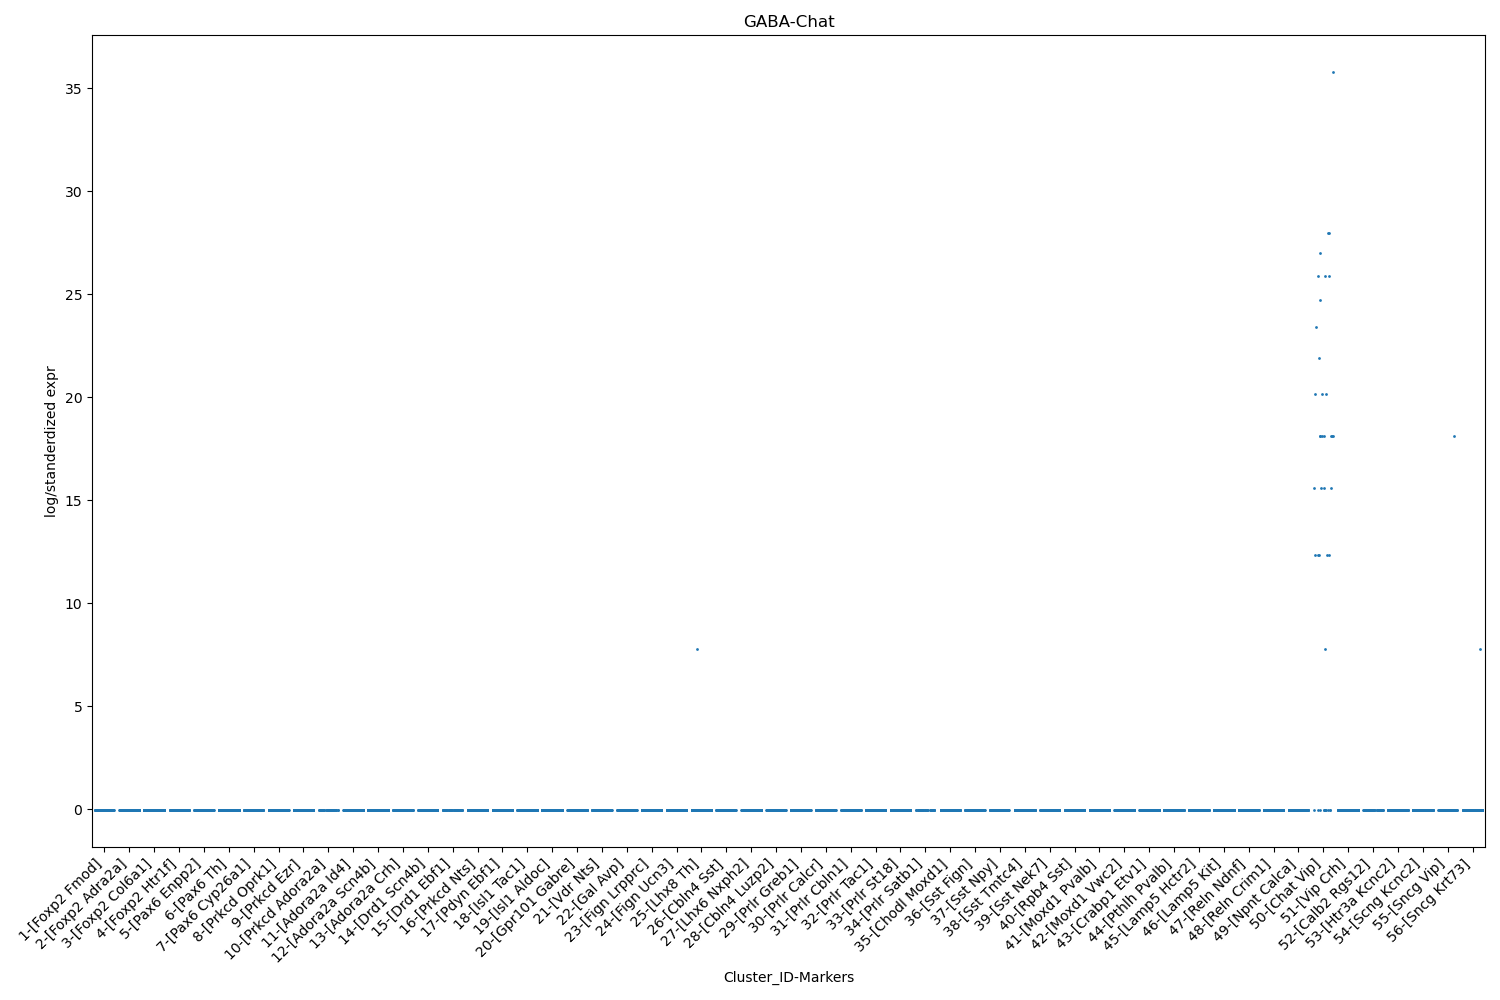

/home/isaac/analysis/scRNA-seq/cell_comparison.py:180: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")


In [260]:
xticks = cc.gene_explorer('Chat', 'amy', amy_df_gaba_expr_ge_cv_ls, amy_metadata_df_gaba,output_folder = '/bigdata/isaac/gaba_files/gene_explorer/',markers = True)

<IPython.core.display.Javascript object>


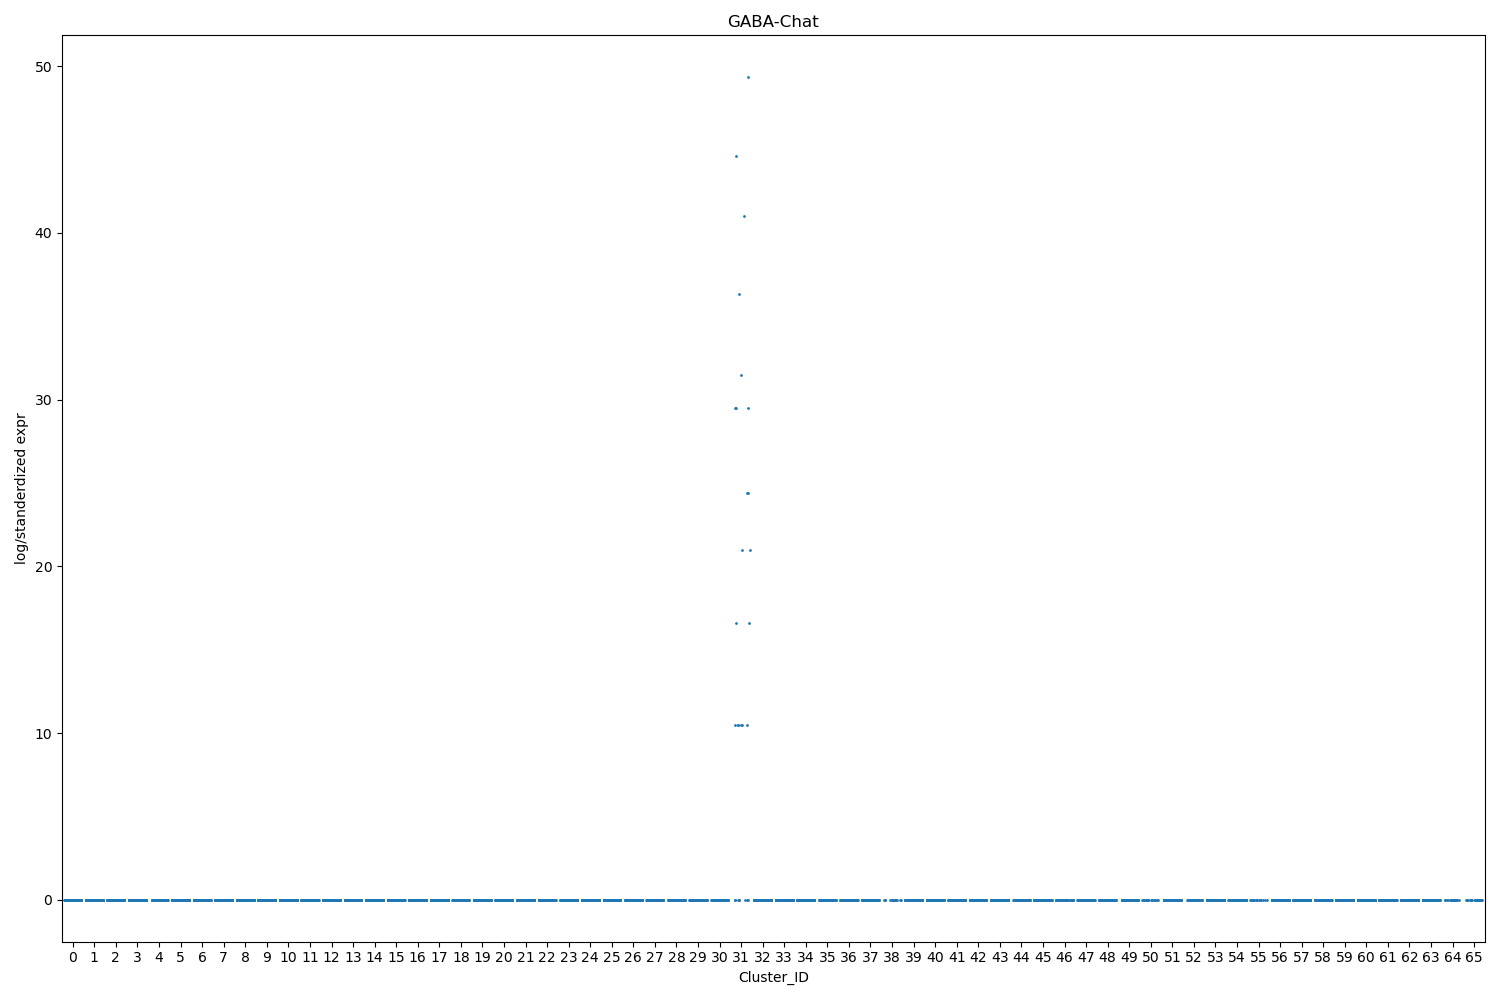

In [268]:
xticks = cc.gene_explorer('Chat','sd', gaba_df_prelinkage_ls, gaba_meta_data_df_prelinkage, output_folder= '/bigdata/isaac/gaba_files/gene_explorer/', markers = False)

<IPython.core.display.Javascript object>


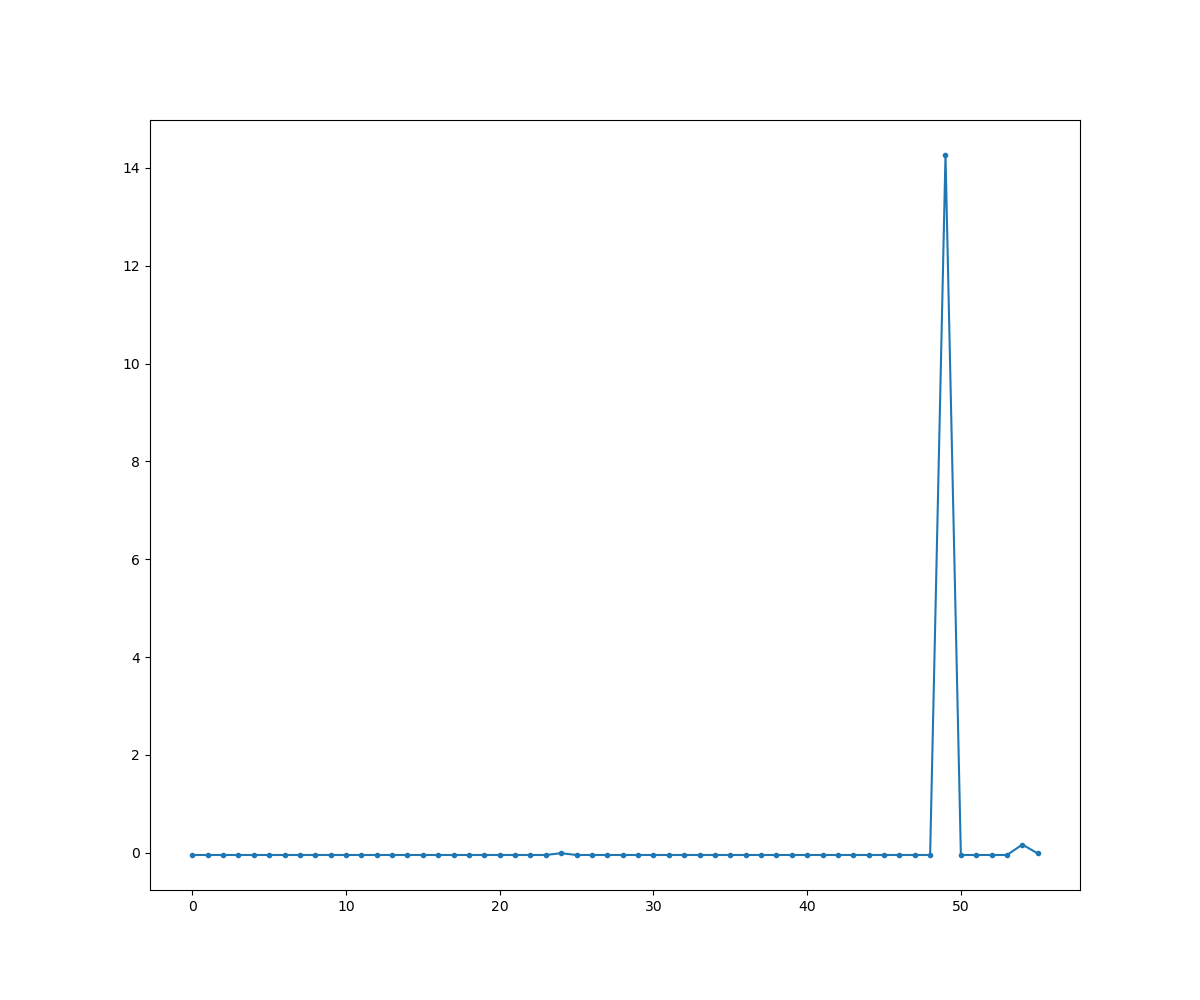

In [217]:
fig,ax = plt.subplots(figsize = (12,10))
ax.plot(np.array(amy_avgs.loc['Chat']), '.-')
#ax.set_xticklabels(xticks)
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha="right")
plt.show()

Use 2024-07-10 dict with removed IEGs

In [286]:
#with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict2024-06-07.json') as json_data:
#with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict_2024-07-10.json') as json_data:
    #gaba_cl_mg_dict = json.load(json_data)
with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict_2024-07-23.json') as json_data:
    gaba_cl_mg_dict = json.load(json_data)

In [287]:
gaba_cl_mg_dict

{'31': ['Chat',
  'Th',
  'Hspb8',
  'Lhx8',
  'Isl1',
  'Matn2',
  'Ndrg1',
  'Deptor',
  'Pbx3',
  'Slc10a4',
  'Nkx2-1',
  'Zic1',
  'Ngfr',
  'Trap1a',
  'Slc5a7',
  'Slc18a3',
  'Ntrk1'],
 '12': ['Dkk2',
  'Rbp1',
  'Creb3l1',
  'Pdyn',
  'Fbn2',
  'Wfs1',
  'Map3k15',
  'Prok2',
  'Prdm13',
  'Esr1',
  'Hs3st6',
  'Cd68'],
 '42': ['Brinp3',
  'Arpp21',
  'Tmem100',
  'C1ql1',
  'Pappa',
  'Rcn1',
  'Cartpt',
  'Dkk3'],
 '43': ['Jsrp1', 'Unc13c', 'Crtac1', 'Phxr4', 'Clca3a1', 'Tmem26', 'Ddc'],
 '40': ['Apoc3', 'Igfbp6', 'Rprm'],
 '39': ['Cck', 'Bmpr1b', 'Grp', 'Slc35d3'],
 '36': ['Pde1c', 'Ramp3', 'Ppp1r17', 'Cbln1', 'Cckar', 'Plagl1', 'Prlr'],
 '55': ['Kcng2',
  'Klhl14',
  'Fam159b',
  'Gm28884',
  'Brs3',
  'Defb1',
  'St18',
  'Gm17660',
  'Chst8',
  'Gpd1'],
 '65': ['Phgdh'],
 '33': [],
 '16': ['Calcr', 'Gpc3', 'Myl4'],
 '38': ['Gm5141', 'Pgr15l'],
 '2': ['Col18a1'],
 '20': ['Lamb3', 'Greb1'],
 '35': ['Msn'],
 '0': ['Brinp1', 'Gpr101'],
 '14': ['Rxfp1', 'Ccdc153', 'Dnah5', 'N

In [353]:
gaba_df_prelinkage_ls.shape

(378, 13529)

In [263]:
gaba_cl_mg_dict_updated = cc.get_updated_cl_mg_dict(gaba_cl_mg_dict,gaba_df_prelinkage_ls)

In [264]:
gaba_cl_mg_dict_updated

{'31': ['Chat',
  'Th',
  'Lhx8',
  'Isl1',
  'Ndrg1',
  'Pbx3',
  'Slc10a4',
  'Zic1',
  'Ngfr',
  'Slc5a7',
  'Slc18a3'],
 '12': ['Dkk2', 'Rbp1', 'Creb3l1', 'Pdyn', 'Wfs1', 'Prok2', 'Esr1', 'Cd68'],
 '42': ['Arpp21', 'C1ql1', 'Pappa', 'Rcn1', 'Cartpt', 'Dkk3'],
 '43': ['Jsrp1', 'Unc13c', 'Crtac1', 'Clca3a1', 'Ddc'],
 '40': ['Igfbp6', 'Rprm'],
 '39': ['Cck', 'Grp'],
 '36': ['Pde1c', 'Ppp1r17', 'Cbln1', 'Plagl1', 'Prlr'],
 '55': ['Klhl14', 'Fam159b', 'Brs3', 'Defb1', 'St18', 'Chst8', 'Gpd1'],
 '65': [],
 '33': [],
 '16': ['Calcr', 'Gpc3'],
 '38': ['Pgr15l'],
 '2': [],
 '20': ['Greb1'],
 '35': [],
 '0': ['Gpr101'],
 '14': ['Rxfp1', 'Dnah5', 'Lypd1'],
 '4': ['Myh7', 'Il1rapl2', 'Ccdc42', 'Ngb'],
 '5': ['Col23a1'],
 '3': [],
 '15': ['Fxyd1', 'Rmst'],
 '11': [],
 '10': [],
 '6': ['Pde11a', '4833423E24Rik', 'Col11a1'],
 '21': ['Pax6', 'Npnt', 'Sel1l3'],
 '41': ['Calca', 'D030055H07Rik'],
 '37': ['Dsc3', 'Angpt1'],
 '25': ['Adcyap1', 'C1ql3', 'Slc17a6'],
 '22': ['Syt2', 'Pou3f2', 'Tac2', 'Lm

In [180]:
sd_shared_cl_mg_dict, connector_df_alt_lco_marker_shared_top = cc.build_corr_table_shared_top(heatmap_argmax_df_alt_lco,
                                                     corr_matrix_manual_alt_lco,
                                                     all_m_u,
                                                     amy_metadata_df_gaba,
                                                     gaba_cl_mg_dict_updated)

In [181]:
sd_shared_cl_mg_dict

{'31': ['Chat', 'Th'],
 '36': ['Prlr', 'Pde1c'],
 '16': ['Calcr', 'Gpc3'],
 '41': ['Calca', 'D030055H07Rik'],
 '24': ['Gal', 'Arhgap36'],
 '56': ['Vip', 'Aebp1'],
 '57': ['Krt73', 'Sncg'],
 '53': ['Reln', 'Ndnf'],
 '59': ['Kit', 'Egfr'],
 '61': ['Pthlh', 'Pvalb'],
 '63': ['Moxd1', '3110035E14Rik']}

In [266]:
gaba_mg_cl_dict_final = cc.create_mg_cl_dict_final(gaba_cl_mg_dict,sd_shared_cl_mg_dict)

In [267]:
sorted(gaba_mg_cl_dict_final.items())

[(0, ['Brinp1', 'Gpr101']),
 (1, ['Dlk1', 'Cntnap5a']),
 (2, ['Col18a1']),
 (3, ['Ddit4l']),
 (4, ['Spint1', 'Myh7']),
 (5, ['Col23a1']),
 (6, ['Scn7a', 'Pde11a']),
 (7, ['Oprk1']),
 (8, ['Npy2r']),
 (9, ['Plscr4', 'Nxph2']),
 (10, []),
 (11, []),
 (12, ['Dkk2', 'Rbp1']),
 (13, ['Zbtb20', 'Cbln4']),
 (14, ['Rxfp1', 'Ccdc153']),
 (15, ['Plk5', 'Fxyd1']),
 (16, ['Calcr', 'Gpc3']),
 (17, ['A730046J19Rik', 'Tspan9']),
 (18, ['Dach1', 'Cyp26b1']),
 (19, ['AF529169', 'Col6a1']),
 (20, ['Lamb3', 'Greb1']),
 (21, ['Pax6', 'Npnt']),
 (22, ['Syt2', 'Satb2']),
 (23, ['Npsr1']),
 (24, ['Gal', 'Arhgap36']),
 (25, ['Nrn1', 'Adcyap1']),
 (26, ['Zfp503', 'Ebf1']),
 (27, ['Drd5', 'Gbx2']),
 (28, ['Gpc4']),
 (29, ['Rnf152', 'Bdnf']),
 (30, ['Pcdh11x', 'Tac1']),
 (31, ['Chat', 'Th']),
 (32, ['Coro6', 'Chrna2']),
 (33, []),
 (35, ['Msn']),
 (36, ['Prlr', 'Pde1c']),
 (37, ['Mfge8', 'Dsc3']),
 (38, ['Gm5141', 'Pgr15l']),
 (39, ['Cck', 'Bmpr1b']),
 (40, ['Apoc3', 'Igfbp6']),
 (41, ['Calca', 'D030055H07Rik'])

In [154]:
#############################manually add missing keys...############################

In [174]:
gaba_mg_cl_dict_final.update({34:[],52:[],54:[],64:[]})

In [168]:
gaba_mg_cl_dict_final.pop(65)

['Phgdh']

In [175]:
len(gaba_mg_cl_dict_final)

66

In [176]:
###KEEP########
gaba_mg_cl_dict_final_sorted = {key:value for key, value in sorted(gaba_mg_cl_dict_final.items(), key=lambda item: int(item[0]))}

In [269]:
#len(np.arange(-1,np.max(np.array(connector_df_alt_lco['corr_cluster'])))+1)

In [232]:
gaba_mg_cl_dict_final_sorted

{0: ['Brinp1', 'Gpr101'],
 1: ['Dlk1', 'Cntnap5a'],
 2: ['Col18a1'],
 3: ['Ddit4l'],
 4: ['Spint1', 'Myh7'],
 5: ['Col23a1'],
 6: ['Scn7a', 'Pde11a'],
 7: ['Oprk1'],
 8: ['Npy2r'],
 9: ['Plscr4', 'Nxph2'],
 10: [],
 11: [],
 12: ['Dkk2', 'Rbp1'],
 13: ['Zbtb20', 'Cbln4'],
 14: ['Rxfp1', 'Ccdc153'],
 15: ['Plk5', 'Fxyd1'],
 16: ['Calcr', 'Gpc3'],
 17: ['A730046J19Rik', 'Tspan9'],
 18: ['Dach1', 'Cyp26b1'],
 19: ['AF529169', 'Col6a1'],
 20: ['Lamb3', 'Greb1'],
 21: ['Pax6', 'Npnt'],
 22: ['Syt2', 'Satb2'],
 23: ['Npsr1'],
 24: ['Gal', 'Arhgap36'],
 25: ['Nrn1', 'Adcyap1'],
 26: ['Zfp503', 'Ebf1'],
 27: ['Drd5', 'Gbx2'],
 28: ['Gpc4'],
 29: ['Rnf152', 'Bdnf'],
 30: ['Pcdh11x', 'Tac1'],
 31: ['Chat', 'Th'],
 32: ['Coro6', 'Chrna2'],
 33: [],
 34: [],
 35: ['Msn'],
 36: ['Prlr', 'Pde1c'],
 37: ['Mfge8', 'Dsc3'],
 38: ['Gm5141', 'Pgr15l'],
 39: ['Cck', 'Bmpr1b'],
 40: ['Apoc3', 'Igfbp6'],
 41: ['Calca', 'D030055H07Rik'],
 42: ['Brinp3', 'Arpp21'],
 43: ['Jsrp1', 'Unc13c'],
 44: ['Gpr88', 'Lr

In [231]:
gaba_mg_cl_dict_final_sorted.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [779]:
gaba_mg_cl_dict_final_sorted.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [264]:
np.arange(-1,np.max(np.array(connector_df_alt_lco['corr_cluster'])))+1

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64])

In [781]:
sd_tics = [k for k,v in gaba_mg_cl_dict_final_sorted.items() if v]

In [782]:
sd_tics

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 53,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 65]

In [783]:
len(sd_tics)

58

In [784]:
len(gaba_mg_cl_dict_final.keys())

66

In [177]:
sd_labels = [f"{key} {'-'.join(value)}" for key, value in gaba_mg_cl_dict_final_sorted.items() if value]

In [786]:
sd_labels

['0 Brinp1-Gpr101',
 '1 Dlk1-Cntnap5a',
 '2 Col18a1',
 '3 Ddit4l',
 '4 Spint1-Myh7',
 '5 Col23a1',
 '6 Scn7a-Pde11a',
 '7 Oprk1',
 '8 Npy2r',
 '9 Plscr4-Nxph2',
 '12 Dkk2-Rbp1',
 '13 Zbtb20-Cbln4',
 '14 Rxfp1-Ccdc153',
 '15 Plk5-Fxyd1',
 '16 Calcr-Gpc3',
 '17 A730046J19Rik-Tspan9',
 '18 Dach1-Cyp26b1',
 '19 AF529169-Col6a1',
 '20 Lamb3-Greb1',
 '21 Pax6-Npnt',
 '22 Syt2-Satb2',
 '23 Npsr1',
 '24 Gal-Arhgap36',
 '25 Nrn1-Adcyap1',
 '26 Zfp503-Ebf1',
 '27 Drd5-Gbx2',
 '28 Gpc4',
 '29 Rnf152-Bdnf',
 '30 Pcdh11x-Tac1',
 '31 Chat-Th',
 '32 Coro6-Chrna2',
 '35 Msn',
 '36 Prlr-Pde1c',
 '37 Mfge8-Dsc3',
 '38 Gm5141-Pgr15l',
 '39 Cck-Bmpr1b',
 '40 Apoc3-Igfbp6',
 '41 Calca-D030055H07Rik',
 '42 Brinp3-Arpp21',
 '43 Jsrp1-Unc13c',
 '44 Gpr88-Lrpprc',
 '45 Nts',
 '46 Ankrd63-Upb1',
 '47 Lpl-Adamtsl2',
 '48 Egln3-Ogfrl1',
 '49 Prrx1',
 '50 9830147E19Rik-Pcdhb22',
 '53 Ndnf-Reln',
 '55 Kcng2-Klhl14',
 '56 Vip-Aebp1',
 '57 Krt73-Sncg',
 '58 Id2-Hapln1',
 '59 Kit-Egfr',
 '60 Lgals1-Cort',
 '61 Pvalb-P

In [810]:
type(sd_labels)

list

In [813]:
folder


'/bigdata/isaac/gaba_files/'

In [814]:
#with open(folder + 'sd_labels.txt', 'w') as f:
    #for line in sd_labels:
        #f.write(f"{line}\n")

In [274]:
len(sd_labels)

58

In [270]:
#sorted(cluster_2_markers_dict.items())

In [271]:
#cluster_2_markers_dict_sorted = {key:value for key, value in sorted(cluster_2_markers_dict.items(), key=lambda item: int(item[0]))}
#cluster_2_markers_dict_sorted

In [280]:
sd_labels_df, sd_labels, gaba_mg_cl_dict_final_sorted = cc.generate_sd_labels_df(corr_matrix_manual_alt_lco, gaba_mg_cl_dict_final)

In [281]:
sd_labels_df

lco_index          sd_label sd_label_complete
0         31        [Chat, Th]        31 Chat-Th
1         12      [Dkk2, Rbp1]      12 Dkk2-Rbp1
2         42  [Brinp3, Arpp21]  42 Brinp3-Arpp21
3         43   [Jsrp1, Unc13c]   43 Jsrp1-Unc13c
4         40   [Apoc3, Igfbp6]   40 Apoc3-Igfbp6
..       ...               ...               ...
61        62             [Maf]            62 Maf
62        54                                 54 
63        34                                 34 
64        64                                 64 
65        52                                 52 

[66 rows x 3 columns]

In [282]:
sd_labels

['0 Brinp1-Gpr101',
 '1 Dlk1-Cntnap5a',
 '2 Col18a1',
 '3 Ddit4l',
 '4 Spint1-Myh7',
 '5 Col23a1',
 '6 Scn7a-Pde11a',
 '7 Oprk1',
 '8 Npy2r',
 '9 Plscr4-Nxph2',
 '12 Dkk2-Rbp1',
 '13 Zbtb20-Cbln4',
 '14 Rxfp1-Ccdc153',
 '15 Plk5-Fxyd1',
 '16 Calcr-Gpc3',
 '17 A730046J19Rik-Tspan9',
 '18 Dach1-Cyp26b1',
 '19 AF529169-Col6a1',
 '20 Lamb3-Greb1',
 '21 Pax6-Npnt',
 '22 Syt2-Satb2',
 '23 Npsr1',
 '24 Gal-Arhgap36',
 '25 Nrn1-Adcyap1',
 '26 Zfp503-Ebf1',
 '27 Drd5-Gbx2',
 '28 Gpc4',
 '29 Rnf152-Bdnf',
 '30 Pcdh11x-Tac1',
 '31 Chat-Th',
 '32 Coro6-Chrna2',
 '35 Msn',
 '36 Prlr-Pde1c',
 '37 Mfge8-Dsc3',
 '38 Gm5141-Pgr15l',
 '39 Cck-Bmpr1b',
 '40 Apoc3-Igfbp6',
 '41 Calca-D030055H07Rik',
 '42 Brinp3-Arpp21',
 '43 Jsrp1-Unc13c',
 '44 Gpr88-Lrpprc',
 '45 Nts',
 '46 Ankrd63-Upb1',
 '47 Lpl-Adamtsl2',
 '48 Egln3-Ogfrl1',
 '49 Prrx1',
 '50 9830147E19Rik-Pcdhb22',
 '53 Reln-Ndnf',
 '55 Kcng2-Klhl14',
 '56 Vip-Aebp1',
 '57 Krt73-Sncg',
 '58 Id2-Hapln1',
 '59 Kit-Egfr',
 '60 Lgals1-Cort',
 '61 Pthlh-P

In [271]:
amy_labels_df,amy_labels = cc.generate_amy_labels_df(connector_df_alt_lco_marker_shared_top,corr_matrix_manual_alt_lco)

In [272]:
amy_labels_df

0
1       1 Foxp2-Fmod
2     2 Foxp2-Adra2a
3     3 Foxp2-Col6a1
4      4 Foxp2-Htr1f
5       5 Pax6-Enpp2
6          6 Pax6-Th
7     7 Pax6-Cyp26a1
8      8 Prkcd-Oprk1
9        9 Prkcd-Ezr
10  10 Prkcd-Adora2a
11    11 Adora2a-Id4
12  12 Adora2a-Scn4b
13    13 Adora2a-Crh
14     14 Drd1-Scn4b
15      15 Drd1-Ebf1
16      16 Prkcd-Nts
17      17 Pdyn-Ebf1
18      18 Isl1-Tac1
19     19 Isl1-Aldoc
20   20 Gpr101-Gabre
21        21 Vdr-Nts
22        22 Gal-Avp
23    23 Fign-Lrpprc
24      24 Fign-Ucn3
25        25 Lhx8-Th
26      26 Cbln4-Sst
27     27 Lhx6-Nxph2
28    28 Cbln4-Luzp2
29     29 Prlr-Greb1
30     30 Prlr-Calcr
31     31 Prlr-Cbln1
32      32 Prlr-Tac1
33      33 Prlr-St18
34     34 Prlr-Satb1
35    35 Chodl-Moxd1
36       36 Sst-Fign
37        37 Sst-Npy
38      38 Sst-Tmtc4
39       39 Sst-Nek7
40       40 Rpb4-Sst
41    41 Moxd1-Pvalb
42     42 Moxd1-Vwc2
43    43 Crabp1-Etv1
44    44 Pthlh-Pvalb
45    45 Lamp5-Hctr2
46      46 Lamp5-Kit
47      47 Reln-Ndnf
48     48 Reln-Crim1
49     49 Npnt-Calca
50       50 Chat-Vip
51        51 Vip-Crh
52    52 Calb2-Rgs12
53    53 Htr3a-Kcnc2
54     54 Scng-Kcnc2
55       55 Sncg-Vip
56     56 Sncg-Krt73

In [273]:
amy_labels

['1 Foxp2-Fmod',
 '2 Foxp2-Adra2a',
 '3 Foxp2-Col6a1',
 '4 Foxp2-Htr1f',
 '5 Pax6-Enpp2',
 '6 Pax6-Th',
 '7 Pax6-Cyp26a1',
 '8 Prkcd-Oprk1',
 '9 Prkcd-Ezr',
 '10 Prkcd-Adora2a',
 '11 Adora2a-Id4',
 '12 Adora2a-Scn4b',
 '13 Adora2a-Crh',
 '14 Drd1-Scn4b',
 '15 Drd1-Ebf1',
 '16 Prkcd-Nts',
 '17 Pdyn-Ebf1',
 '18 Isl1-Tac1',
 '19 Isl1-Aldoc',
 '20 Gpr101-Gabre',
 '21 Vdr-Nts',
 '22 Gal-Avp',
 '23 Fign-Lrpprc',
 '24 Fign-Ucn3',
 '25 Lhx8-Th',
 '26 Cbln4-Sst',
 '27 Lhx6-Nxph2',
 '28 Cbln4-Luzp2',
 '29 Prlr-Greb1',
 '30 Prlr-Calcr',
 '31 Prlr-Cbln1',
 '32 Prlr-Tac1',
 '33 Prlr-St18',
 '34 Prlr-Satb1',
 '35 Chodl-Moxd1',
 '36 Sst-Fign',
 '37 Sst-Npy',
 '38 Sst-Tmtc4',
 '39 Sst-Nek7',
 '40 Rpb4-Sst',
 '41 Moxd1-Pvalb',
 '42 Moxd1-Vwc2',
 '43 Crabp1-Etv1',
 '44 Pthlh-Pvalb',
 '45 Lamp5-Hctr2',
 '46 Lamp5-Kit',
 '47 Reln-Ndnf',
 '48 Reln-Crim1',
 '49 Npnt-Calca',
 '50 Chat-Vip',
 '51 Vip-Crh',
 '52 Calb2-Rgs12',
 '53 Htr3a-Kcnc2',
 '54 Scng-Kcnc2',
 '55 Sncg-Vip',
 '56 Sncg-Krt73']

In [226]:
folder

'/bigdata/isaac/gaba_files/'

<IPython.core.display.Javascript object>


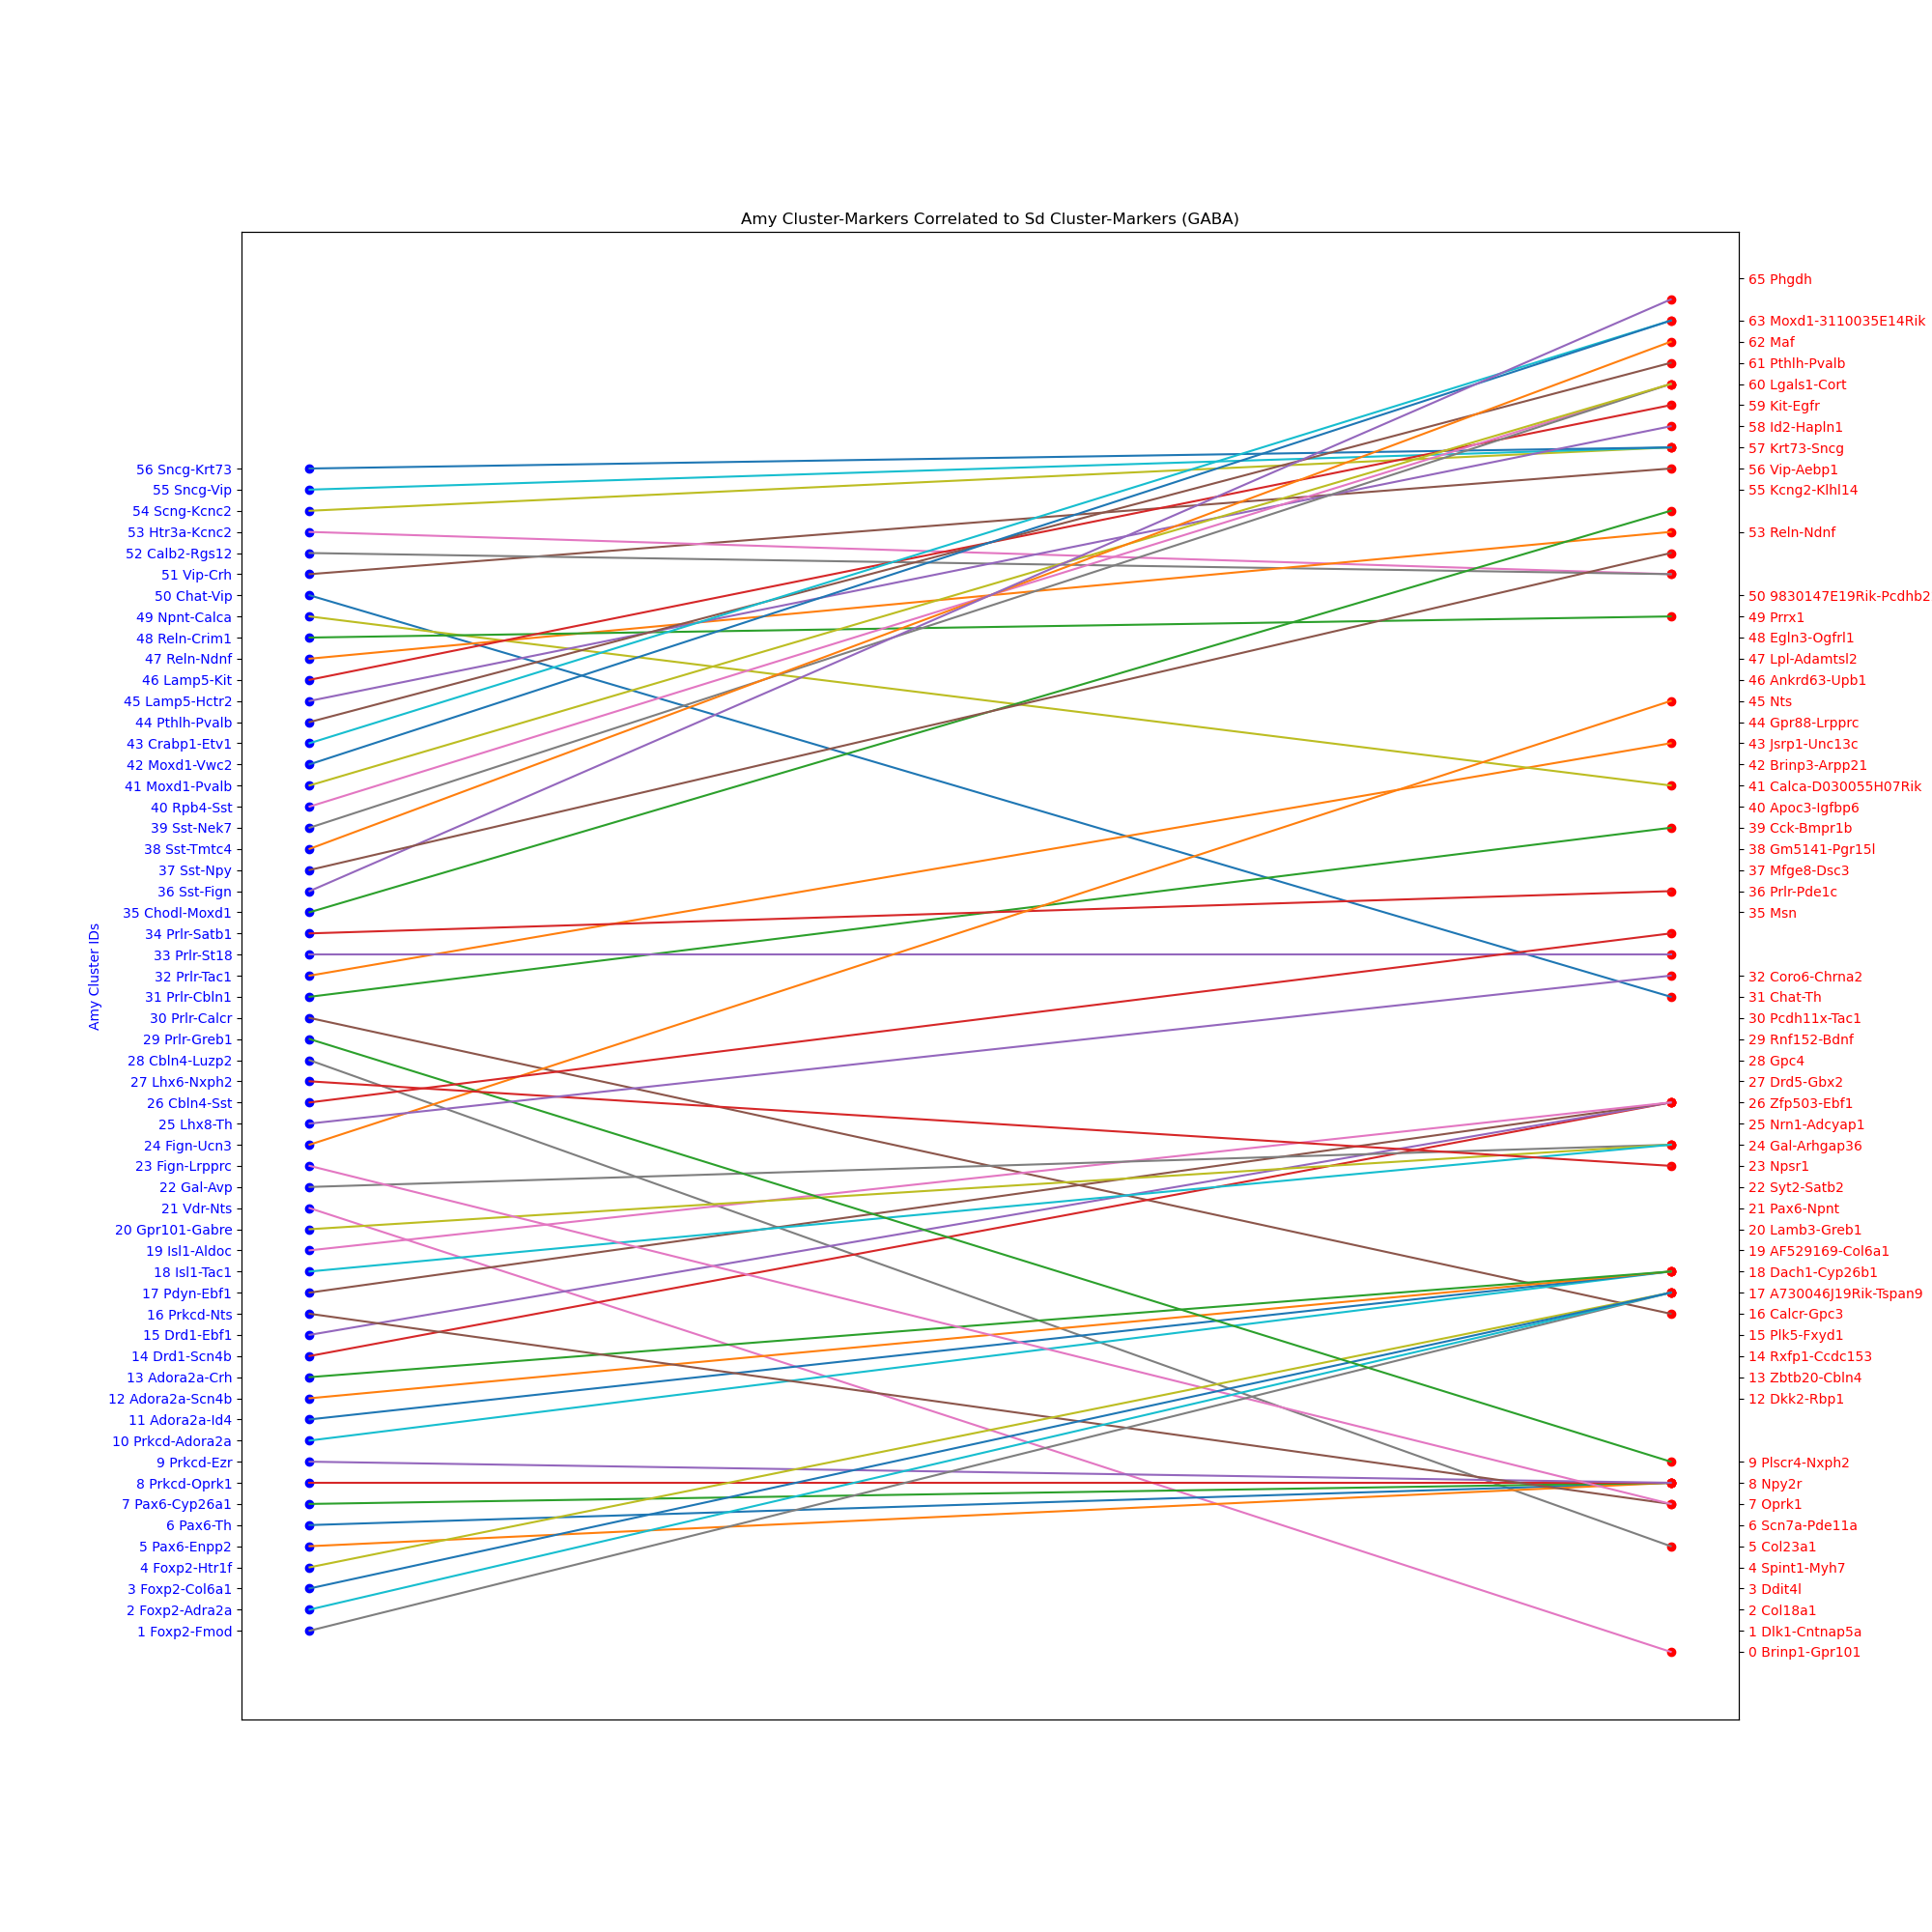

In [283]:
cc.plot_connector_plot_with_labels(connector_df_alt_lco_marker_shared_top,gaba_mg_cl_dict_final_sorted,sd_labels,amy_labels, folder,'GABA')

In [ ]:
# update corr plots with marker pari labels

In [284]:
today

'2024-08-21'

In [338]:
folder = '/bigdata/isaac/gaba_files/'

In [285]:
cc.plot_correlation_w_labels(corr_matrix_manual_alt_lco_sorted,sd_labels_df,amy_labels_df, folder, 'GABA',savefig=False)

Launching server at http://localhost:43499


:HeatMap   [columns,index]   (value)

In [302]:
sd_labels_df

lco_index          sd_label sd_label_complete
0         31        [Chat, Th]        31 Chat-Th
1         12      [Dkk2, Rbp1]      12 Dkk2-Rbp1
2         42  [Brinp3, Arpp21]  42 Brinp3-Arpp21
3         43   [Jsrp1, Unc13c]   43 Jsrp1-Unc13c
4         40   [Apoc3, Igfbp6]   40 Apoc3-Igfbp6
..       ...               ...               ...
61        62             [Maf]            62 Maf
62        54                                 54 
63        34                                 34 
64        64                                 64 
65        52                                 52 

[66 rows x 3 columns]

In [ ]:
##update corr plot with dropped/merged clusters (from dimorph_processing.py)

In [296]:
#from dp heatmap analysis 
clusters_to_drop = [33, 38, 3, 11, 10, 25, 51, 34, 52, 54, 64, 65]

In [305]:
sd_labels_df_filtered_merged = sd_labels_df[~sd_labels_df['lco_index'].isin(clusters_to_drop)]

In [314]:
sd_labels_df_filtered_merged.shape

(54, 3)

In [310]:
corr_matrix_manual_alt_lco_sorted_filtered_merged = corr_matrix_manual_alt_lco_sorted.drop(columns = clusters_to_drop)

In [313]:
corr_matrix_manual_alt_lco_sorted_filtered_merged.shape

(56, 54)

In [315]:
folder

'/bigdata/isaac/gaba_files/'

In [340]:
cc.plot_correlation_w_labels(corr_matrix_manual_alt_lco_sorted_filtered_merged,sd_labels_df_filtered_merged,amy_labels_df, folder, 'GABA_filtered_merged',savefig=True)

Launching server at http://localhost:41563


:HeatMap   [columns,index]   (value)

In [318]:
today

'2024-08-21'

In [293]:
sd_avgs_lco.columns

Index([31, 12, 42, 43, 40, 39, 36, 55, 65, 33, 16, 38,  2, 20, 35,  0, 14,  4,
        5,  3, 15, 11, 10,  6, 21, 41, 37, 25, 18, 26, 22, 27, 24, 28,  8,  7,
       19, 17, 44, 46, 45,  9, 47, 50, 23,  1, 13, 29, 30, 32, 56, 51, 57, 53,
       48, 49, 59, 58, 61, 60, 63, 62, 54, 34, 64, 52],
      dtype='object')

In [815]:
folder

'/bigdata/isaac/gaba_files/'

In [816]:
#sd_labels_df.to_csv(folder + 'gaba_sd_labels_df_' + today + '.csv')

In [817]:
#amy_labels_df.to_csv(folder + 'gaba_amy_labels_df_' + today + '.csv')

## Vglut1 Analysis <a name="vglut1_analysis"></a>

In [320]:
all_cell_classes

['Astro',
 'Astro_SC',
 'Astro_agt',
 'COP',
 'EC',
 'Epend',
 'GABA',
 'OL',
 'OPC',
 'OPC_cycling',
 'Peri',
 'VGLUT1',
 'VGLUT2',
 'VLMC',
 'VSM',
 'microglia',
 'pvm']

### Process VGLUT1 Amy data

removing # duplicate gene rows:  65
removing  53  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']
Total genes reduced from 27880 to 13762


<IPython.core.display.Javascript object>


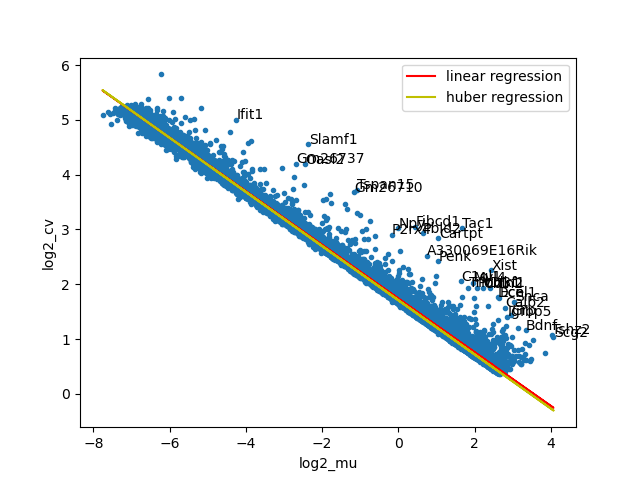

<IPython.core.display.Javascript object>


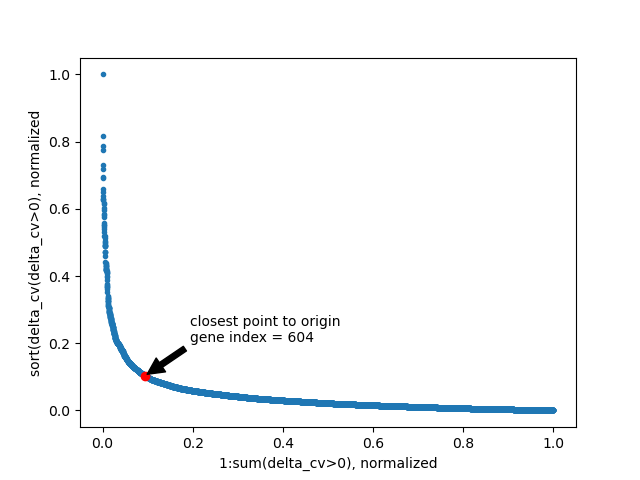

column (gene) mean after standardization: 0.00
column (gene) sigma after standardization: 1.00


In [321]:
amy_df_VGLUT1_expr_ge_cv_ls, amy_metadata_df_VGLUT1 = cc.process_amy_data_class(amy_df,amy_metadata_df,IEG_list,cell_class='VGLUT1')

In [323]:
#save to file

folder = '/bigdata/isaac/Vglut1_files/'

file1 = 'amy_df_VGLUT1_expr_ge_cv_ls_orig' 
file2 = 'amy_metadata_df_VGLUT1_orig' 

#amy_df_VGLUT1_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_VGLUT1.to_json(folder+file2+'.json')

In [350]:
folder = '/bigdata/isaac/Vglut1_files/'
amy_df_VGLUT1_expr_ge_cv_ls_orig = pd.read_feather(folder + 'amy_df_VGLUT1_expr_ge_cv_ls_orig.feather')
amy_metadata_df_VGLUT1_orig = pd.read_json(folder + 'amy_metadata_df_VGLUT1_orig.json')

### Load VGLUT1 SD data

In [324]:
folder

'/bigdata/isaac/Vglut1_files/'

In [345]:
folder = '/bigdata/isaac/Vglut1_files/'

VGLUT1_meta_data_df_plis = pd.read_json(folder + 'Vglut1_meta_data_df_plis2024-08-21.json')

VGLUT1_df_prelinkage_ls_orig = pd.read_feather(folder + 'Vglut1_df_pre_linkage_ls_2024-08-21.feather')
VGLUT1_metadata_df_prelinkage_ls_orig = pd.read_json(folder + 'Vglut1_meta_data_df_pre_linkage_2024-08-21.json')


### Get intersection

In [326]:
lco = pd.unique(VGLUT1_meta_data_df_plis.loc['cluster_label'])
lco

array([28, 27, 17, 11, 14, 18, 19, 3, 6, 8, 12, 15, 0, 16, 5, 9, 26, 13,
       22, 21, 25, 24, 1, 10, 20, 23, 2, 7, 4], dtype=object)

In [327]:
amy_df_VGLUT1_expr_ge_cv_ls, VGLUT1_df_prelinkage_ls = cc.get_df_gene_intersection(VGLUT1_df_prelinkage_ls_orig,amy_df_VGLUT1_expr_ge_cv_ls,IEG_list)

removing  0  genes found in  ['Btg2', 'Jun', 'Egr4', 'Fosb', 'Junb', 'Gadd45g', 'Fos', 'Arc', 'Nr4a1', 'Npas4', 'Coq10b', 'Tns1', 'Per2', 'Ptgs2', 'Rnd3', 'Tnfaip6', 'Srxn1', 'Tiparp', 'Ccnl1', 'Mcl1', 'Dnajb5', 'Nr4a3', 'Fosl2', 'Nptx2', 'Rasl11a', 'Mest', 'Sertad1', 'Egr2', 'Midn', 'Gadd45b', 'Dusp6', 'Irs2', 'Plat', 'Ier2', 'Rrad', 'Tpbg', 'Csrnp1', 'Peli1', 'Per1', 'Kdm6b', 'Inhba', 'Plk2', 'Ifrd1', 'Baz1a', 'Trib1', 'Pim3', 'Lrrk2', 'Dusp1', 'Cdkn1a', 'Pim1', 'Sik1', 'Frat2', 'Dusp5']
Index(['Tac1', 'Xist', 'Slamf1', 'Cartpt', 'Fibcd1', 'Pbld2', 'Tspan15',
       'Snca', 'Dlk1', 'Gm26710',
       ...
       'Emilin1', 'Hspb2', 'Vwc2', 'Fgfr1', 'Wnt5a', 'Gabrg3', 'Nhs',
       'Tmem215', 'Rims3', 'Itpr2'],
      dtype='object', length=315)


In [328]:
amy_df_VGLUT1_expr_ge_cv_ls.shape

(315, 11947)

In [329]:
VGLUT1_df_prelinkage_ls.shape

(315, 10369)

### Checkpoint - save intersected data/metadata to file / load from here

In [119]:
folder

'/bigdata/isaac/gaba_files/'

In [332]:
#save to file

folder = '/bigdata/isaac/Vglut1_files/'

file1 = 'amy_df_VGLUT1_expr_ge_cv_ls_cell_comp' 
file2 = 'amy_metadata_df_VGLUT1_cell_comp' 

#amy_df_VGLUT1_expr_ge_cv_ls.to_feather(folder+file1+'.feather')
#amy_metadata_df_VGLUT1.to_json(folder+file2+'.json')

#################################

file1 = 'VGLUT1_df_prelinkage_ls_cell_comp' 
file2 = 'VGLUT1_meta_data_df_prelinkage_cell_comp' 

#VGLUT1_df_prelinkage_ls.to_feather(folder+file1+'.feather')
#VGLUT1_metadata_df_prelinkage_ls_orig.to_json(folder+file2+'.json')


In [52]:
#load data
folder = '/bigdata/isaac/VGLUT1_files/'

#amy_df_VGLUT1_expr_ge_cv_ls = pd.read_feather(folder + 'amy_df_VGLUT1_expr_ge_cv_ls_cell_comp.feather')
#amy_metadata_df_VGLUT1 = pd.read_json(folder + 'amy_metadata_df_VGLUT1_cell_comp.json')

#VGLUT1_df_prelinkage_ls = pd.read_feather(folder + 'VGLUT1_df_prelinkage_ls_cell_comp.feather')
#VGLUT1_meta_data_df_prelinkage = pd.read_json(folder + 'VGLUT1_meta_data_df_prelinkage_cell_comp.json' )

### Compute avg expression for all genes, for every cluster

In [333]:
amy_avgs = dp.compute_avg_expr_per_cluster_label(amy_df_VGLUT1_expr_ge_cv_ls,amy_metadata_df_VGLUT1)

In [334]:
amy_avgs

1         2         3         4         5         6         7   \
Tac1    -0.194167 -0.126893 -0.178076 -0.016315 -0.036845 -0.118406 -0.124385   
Xist    -0.047641 -0.117509 -0.169712 -0.203929  0.150508  0.064379 -0.098817   
Slamf1  -0.105871  0.001953 -0.066666  0.052993 -0.105871  0.010102 -0.039187   
Cartpt  -0.021226 -0.123727 -0.000883  0.004818 -0.219082 -0.181355 -0.130713   
Fibcd1  -0.200757 -0.096971 -0.083385 -0.200757 -0.200757 -0.041012 -0.172215   
...           ...       ...       ...       ...       ...       ...       ...   
Gabrg3   0.143111  0.459558  0.008212 -0.115661 -0.417358  0.409043  0.560066   
Nhs      0.052265 -0.201807 -0.231616 -0.265213 -0.139388 -0.171996  0.278677   
Tmem215  -0.20894  0.404455  0.600378  0.659114 -0.187673 -0.238815  0.616408   
Rims3     0.03584  -0.20809 -0.216283 -0.181919 -0.095112 -0.117987  1.084829   
Itpr2    0.059283 -0.080312 -0.052185 -0.083864  0.006859 -0.063093 -0.027811   

               8         9         10  ...        23        24        25  \
Tac1    -0.161997 -0.079559  4.152479  ... -0.123742 -0.217711  0.004919   
Xist     0.032376  0.105497  0.301467  ...   0.13514  0.035949  0.025222   
Slamf1   0.125944 -0.105871 -0.105871  ... -0.005924 -0.105871 -0.016506   
Cartpt  -0.083667 -0.124451 -0.169563  ...  -0.14453  0.818864 -0.072145   
Fibcd1  -0.149736  0.496483 -0.016769  ... -0.185782 -0.200757  0.091133   
...           ...       ...       ...  ...       ...       ...       ...   
Gabrg3   0.745752 -0.405415  0.356747  ... -0.567281 -0.613648 -0.389966   
Nhs     -0.082943  0.539967 -0.214153  ...  0.025154 -0.265213  0.115833   
Tmem215 -0.206852  0.446499   0.99352  ... -0.358244 -0.411616  0.059611   
Rims3   -0.090978   0.94758  0.651262  ...  -0.04311  0.059749 -0.066852   
Itpr2   -0.099696  0.388814 -0.094099  ... -0.014974 -0.005451 -0.052392   

               26        27        28        29        30        31        32  
Tac1     4.263656 -0.096108 -0.135938 -0.244471 -0.179483 -0.128544 -0.203009  
Xist    -0.017394 -0.154389 -0.222226 -0.111651  0.757116  0.121067  0.404711  
Slamf1  -0.047439  0.043648  0.049546  0.094511  0.015168 -0.024519 -0.037588  
Cartpt  -0.089928 -0.101676 -0.166746 -0.172837 -0.260137  0.144345  -0.21274  
Fibcd1  -0.112006 -0.112697 -0.181824 -0.075747 -0.200757 -0.159702  0.054471  
...           ...       ...       ...       ...       ...       ...       ...  
Gabrg3    0.09582 -0.193156  0.680269  0.222021   0.15227 -0.377551  -0.05809  
Nhs      0.113901  0.073143  0.007143 -0.054186  0.318324  0.248706 -0.079451  
Tmem215  0.963422 -0.064432  -0.26546 -0.072393 -0.129807 -0.067544   0.02234  
Rims3    0.648454 -0.050085  0.362177 -0.026185 -0.139134 -0.002799 -0.081028  
Itpr2    -0.03938  0.280845 -0.115906   0.48213   0.02248 -0.104733  0.141938  

[315 rows x 32 columns]

In [336]:
sd_avgs = dp.compute_avg_expr_per_cluster_label(VGLUT1_df_prelinkage_ls,VGLUT1_metadata_df_prelinkage_ls_orig)

In [341]:
sd_avgs

0         1         2         3         4         5         6   \
Tac1     4.754467 -0.053088 -0.042159 -0.064116  0.050844   1.28618 -0.083966   
Xist    -0.361803  0.058607  0.078552  0.146347  0.266184 -0.285881 -0.205761   
Slamf1  -0.028496 -0.033431  0.198319 -0.012686 -0.117678  0.161074 -0.023074   
Cartpt   0.001536  0.103509 -0.063013 -0.084758  0.053297  0.366756 -0.101595   
Fibcd1  -0.134204 -0.223408 -0.232025 -0.218476 -0.203807 -0.061643  0.582846   
...           ...       ...       ...       ...       ...       ...       ...   
Gabrg3   0.660577 -0.295231  -0.20253 -0.213352 -0.322647  0.935079 -0.218246   
Nhs      0.050832 -0.081527 -0.126824 -0.265787 -0.158374  0.792793 -0.246684   
Tmem215  1.910817  -0.16515 -0.221981 -0.223587 -0.197219  0.727548  -0.09838   
Rims3    0.753772   -0.0335 -0.236935 -0.219108 -0.018103  1.529063 -0.248727   
Itpr2    0.029429 -0.077258 -0.030892 -0.126337 -0.162291  0.056847 -0.132015   

               7         8         9   ...        19        20        21  \
Tac1      0.01078 -0.074248  0.004949  ... -0.120016 -0.054177 -0.040876   
Xist     0.112704  0.082111  0.091989  ...  -0.12939  0.116864  0.458497   
Slamf1   0.021731 -0.037092  0.252833  ... -0.117678  0.087075 -0.117678   
Cartpt   0.019998  0.394353 -0.068677  ... -0.226919 -0.067612  0.176751   
Fibcd1  -0.189371 -0.148495 -0.200538  ... -0.232025 -0.202361 -0.232025   
...           ...       ...       ...  ...       ...       ...       ...   
Gabrg3  -0.268772 -0.285432  1.511242  ...  -0.21774 -0.228091 -0.322647   
Nhs     -0.068253 -0.243329  0.360712  ... -0.124721   0.01278   0.09032   
Tmem215 -0.025878 -0.234701  2.352586  ... -0.059545 -0.214299  0.118386   
Rims3   -0.222755 -0.267062  1.617096  ... -0.298423 -0.139057 -0.226118   
Itpr2    0.231289 -0.162291 -0.138417  ... -0.162291  -0.10553   0.14674   

               22        23        24        25        26        27        28  
Tac1    -0.033596   -0.0705  -0.12346  0.148131 -0.203812 -0.096371  2.070584  
Xist     0.164031 -0.240626 -0.210843 -0.657833 -0.082362  0.270603  0.620676  
Slamf1  -0.033012  0.186349 -0.026053  0.149866 -0.117678  0.151819  0.216752  
Cartpt  -0.095172 -0.226919 -0.155631  0.033282 -0.118502 -0.077219  1.886787  
Fibcd1  -0.232025 -0.232025 -0.232025 -0.232025 -0.232025 -0.193053 -0.232025  
...           ...       ...       ...       ...       ...       ...       ...  
Gabrg3  -0.322647 -0.322647 -0.259178 -0.229982 -0.322647  1.478926  2.907943  
Nhs     -0.105891  0.257098 -0.107372  0.042359  0.593509 -0.128213  1.985644  
Tmem215 -0.056595 -0.247941 -0.067287   1.25249  0.656652 -0.058926  0.081753  
Rims3   -0.015557 -0.110895 -0.170593 -0.090185 -0.298423 -0.109146  1.415623  
Itpr2   -0.162291 -0.162291 -0.086092 -0.162291  0.301255 -0.098872  0.115837  

[315 rows x 29 columns]

In [384]:
heatmap2, heatmap_argmax_df_alt_lco, corr_matrix_manual_alt_lco, corr_matrix_manual_alt_lco_sorted = cc.plot_correlation(sd_avgs,amy_avgs,lco)
# Display the plot
hvplot.show(heatmap2)
    
# Ensure output is displayed inline
hv.output(heatmap2, backend='bokeh')

Launching server at http://localhost:35373


:HeatMap   [columns,index]   (value)

In [351]:
error_genes,all_marker_labels = cc.amy_gene_spell_checker(amy_df_VGLUT1_expr_ge_cv_ls_orig,amy_metadata_df_VGLUT1)
error_genes

/home/isaac/analysis/scRNA-seq/cell_comparison.py:124: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  all_m_u = []


gene,  Zic4 not found in index


['Zic4']

In [352]:
all_marker_labels

[['Bok', 'Pamr1'],
 ['Car12', 'Celsr1'],
 ['Cartpt', 'Fam46a'],
 ['Cbln1', 'Coch'],
 ['Cd36', 'Calb2'],
 ['Dcn', 'C1ql2'],
 ['Eps8', 'Cd44'],
 ['Ermn', 'Mpped1'],
 ['Fbln1', 'Il33'],
 ['Fibcd1', 'Vit'],
 ['Fmo1', 'Rxfp3'],
 ['Gpr101', 'Grem1'],
 ['Gpx3', 'Rxfp1'],
 ['Grp', 'Cpne8'],
 ['Gsg1l', 'Prox1'],
 ['Igfn1', 'Ndst4'],
 ['Mid1', 'Cdh22'],
 ['Oasl2', 'Ifit1'],
 ['Plcxd3', 'Reln'],
 ['Rspo2', 'Sema3e'],
 ['Sema5a', 'Dcn'],
 ['Sim1', 'C1ql1'],
 ['St8sia2', 'Cald1'],
 ['Tac1', 'Igfbp5'],
 ['Thrsp', 'Lamp5'],
 ['Trh', 'Kit'],
 ['Trh', 'Mdga1'],
 ['Trh', 'Medag'],
 ['Trh', 'Rxfp1'],
 ['Trh', 'Slc23a3'],
 ['Wfs1', 'Sorcs3'],
 ['Zic4', 'Trp73']]

In [354]:
folder

'/bigdata/isaac/Vglut1_files/'

In [359]:
with open(folder + 'Vglut1_cl_mg_dict2024-08-21.json') as json_data:
    VGLUT1_cl_mg_dict = json.load(json_data)

In [360]:
VGLUT1_cl_mg_dict

{'28': ['Slc32a1',
  'Rprm',
  'Sv2c',
  'Gpx3',
  'C1ql1',
  'Pou3f1',
  'Rps27rt',
  'Mafb',
  'Gad2',
  'Dlx6os1',
  'Cbln2'],
 '27': ['Arhgdib', 'Sim1'],
 '17': ['Gm11549',
  'Prox1',
  'Eps8',
  'Peg10',
  'Plekhg1',
  'Penk',
  'Pappa',
  'Grp',
  'Atf3'],
 '11': ['Il33', 'Fbln1', 'Prox1os'],
 '14': ['Cplx3', 'Fst', 'Cd44', 'Gm15261'],
 '18': ['Arhgap6', 'Galnt9', 'Dlk1', 'Id4', 'Dcn', 'Mirt1', 'Meis2'],
 '19': ['2410022M11Rik', 'Cd24a', 'Dio3'],
 '3': ['Pde11a', 'Vgll3', 'Ecm2', 'Slc1a3', 'Rspo1'],
 '6': ['Lypd6'],
 '8': ['Bdnf', 'Pcdh11x', 'Abhd11os', 'Llgl2', 'C1ql2'],
 '12': ['Igfbp4', 'Mgp', 'Col6a1', 'Pdlim1', 'Col25a1', 'Sox5'],
 '15': ['Cpne2',
  'Adgrg6',
  'S100a16',
  'Fgf1',
  'Tspan18',
  'Smoc2',
  'Calb2',
  'Kit',
  'Col12a1'],
 '0': ['Angpt1', 'Mt2', 'Tac1', 'Nxph3', 'Nhlh2', 'Cxcl12', 'Igfbpl1'],
 '16': ['Sema5a',
  'Medag',
  'Stxbp6',
  'Cox6a2',
  'Sorcs1',
  'Nxph1',
  'Vwc2',
  'Tshz2',
  'Rims3'],
 '5': ['Snca', 'Foxp2', 'Oprk1', 'Olfm3', 'Rgs12'],
 '9': [

In [357]:
VGLUT1_df_prelinkage_ls.shape

(315, 10369)

In [361]:
VGLUT1_cl_mg_dict_updated = cc.get_updated_cl_mg_dict(VGLUT1_cl_mg_dict,VGLUT1_df_prelinkage_ls)

In [362]:
sd_shared_cl_mg_dict, connector_df_alt_lco_marker_shared_top = cc.build_corr_table_shared_top(heatmap_argmax_df_alt_lco,
                                                     corr_matrix_manual_alt_lco,
                                                     all_marker_labels,
                                                     amy_metadata_df_VGLUT1,
                                                     VGLUT1_cl_mg_dict_updated)

In [363]:
sd_shared_cl_mg_dict

{'27': ['Sim1', 'Arhgdib'],
 '11': ['Il33', 'Fbln1'],
 '14': ['Cd44', 'Cplx3'],
 '18': ['Dcn', 'Arhgap6'],
 '0': ['Tac1', 'Angpt1'],
 '20': ['Reln', 'BC048546']}

In [364]:
VGLUT1_mg_cl_dict_final = cc.create_mg_cl_dict_final(VGLUT1_cl_mg_dict,sd_shared_cl_mg_dict)

In [366]:
sorted(VGLUT1_mg_cl_dict_final.items())

[(0, ['Tac1', 'Angpt1']),
 (1, ['Rab3b']),
 (3, ['Pde11a', 'Vgll3']),
 (5, ['Snca', 'Foxp2']),
 (6, ['Lypd6']),
 (8, ['Bdnf', 'Pcdh11x']),
 (9, ['Spon1', 'Tmem215']),
 (10, []),
 (11, ['Il33', 'Fbln1']),
 (12, ['Igfbp4', 'Mgp']),
 (13, []),
 (14, ['Cd44', 'Cplx3']),
 (15, ['Cpne2', 'Adgrg6']),
 (16, ['Sema5a', 'Medag']),
 (17, ['Gm11549', 'Prox1']),
 (18, ['Dcn', 'Arhgap6']),
 (19, ['2410022M11Rik', 'Cd24a']),
 (20, ['Reln', 'BC048546']),
 (21, ['Nppc', 'Plk5']),
 (22, ['Moxd1']),
 (23, ['Gfod2']),
 (24, []),
 (25, ['Rnf152', 'Ecel1']),
 (26, ['Rxfp1', 'Fam3c']),
 (27, ['Sim1', 'Arhgdib']),
 (28, ['Slc32a1', 'Rprm'])]

In [154]:
#############################manually add missing keys...############################

In [367]:
len(lco)

29

In [369]:
len(VGLUT1_mg_cl_dict_final.keys())

26

In [370]:
VGLUT1_mg_cl_dict_final.update({2:[],4:[],7:[]})

In [371]:
len(VGLUT1_mg_cl_dict_final.keys())

29

In [372]:
corr_matrix_manual_alt_lco.shape

(32, 29)

In [374]:
sd_labels_df, sd_labels, VGLUT1_mg_cl_dict_final_sorted = cc.generate_sd_labels_df(corr_matrix_manual_alt_lco, VGLUT1_mg_cl_dict_final)

In [375]:
sd_labels_df

lco_index                sd_label       sd_label_complete
0         28         [Slc32a1, Rprm]         28 Slc32a1-Rprm
1         27         [Sim1, Arhgdib]         27 Sim1-Arhgdib
2         17        [Gm11549, Prox1]        17 Gm11549-Prox1
3         11           [Il33, Fbln1]           11 Il33-Fbln1
4         14           [Cd44, Cplx3]           14 Cd44-Cplx3
5         18          [Dcn, Arhgap6]          18 Dcn-Arhgap6
6         19  [2410022M11Rik, Cd24a]  19 2410022M11Rik-Cd24a
7          3         [Pde11a, Vgll3]          3 Pde11a-Vgll3
8          6                 [Lypd6]                 6 Lypd6
9          8         [Bdnf, Pcdh11x]          8 Bdnf-Pcdh11x
10        12           [Igfbp4, Mgp]           12 Igfbp4-Mgp
11        15         [Cpne2, Adgrg6]         15 Cpne2-Adgrg6
12         0          [Tac1, Angpt1]           0 Tac1-Angpt1
13        16         [Sema5a, Medag]         16 Sema5a-Medag
14         5           [Snca, Foxp2]            5 Snca-Foxp2
15         9        [Spon1, Tmem215]         9 Spon1-Tmem215
16        26          [Rxfp1, Fam3c]          26 Rxfp1-Fam3c
17        13                      []                     13 
18        22                 [Moxd1]                22 Moxd1
19        21            [Nppc, Plk5]            21 Nppc-Plk5
20        25         [Rnf152, Ecel1]         25 Rnf152-Ecel1
21        24                      []                     24 
22         1                 [Rab3b]                 1 Rab3b
23        10                      []                     10 
24        20        [Reln, BC048546]        20 Reln-BC048546
25        23                 [Gfod2]                23 Gfod2
26         2                      []                      2 
27         7                      []                      7 
28         4                      []                      4

In [377]:
amy_labels_df,amy_labels = cc.generate_amy_labels_df(connector_df_alt_lco_marker_shared_top,corr_matrix_manual_alt_lco)

In [378]:
amy_labels_df

0
1       1 Zic4-Trp73
2     2 Rspo2-Sema3e
3       3 Sema5a-Dcn
4      4 Wfs1-Sorcs3
5       5 Cbln1-Coch
6      6 Thrsp-Lamp5
7        7 Bok-Pamr1
8       8 Sim1-C1ql1
9       9 Gpx3-Rxfp1
10    10 Ermn-Mpped1
11     11 Cd36-Calb2
12   12 Gpr101-Grem1
13      13 Dcn-C1ql2
14  14 Cartpt-Fam46a
15     15 Fmo1-Rxfp3
16     16 Fbln1-Il33
17      17 Eps8-Cd44
18     18 Fibcd1-Vit
19   19 Car12-Celsr1
20      20 Trh-Mdga1
21      21 Trh-Rxfp1
22      22 Trh-Medag
23        23 Trh-Kit
24    24 Trh-Slc23a3
25    25 Plcxd3-Reln
26    26 Tac1-Igfbp5
27    27 Oasl2-Ifit1
28      28 Grp-Cpne8
29  29 St8sia2-Cald1
30    30 Gsg1l-Prox1
31    31 Igfn1-Ndst4
32     32 Mid1-Cdh22

In [379]:
folder

'/bigdata/isaac/Vglut1_files/'

<IPython.core.display.Javascript object>


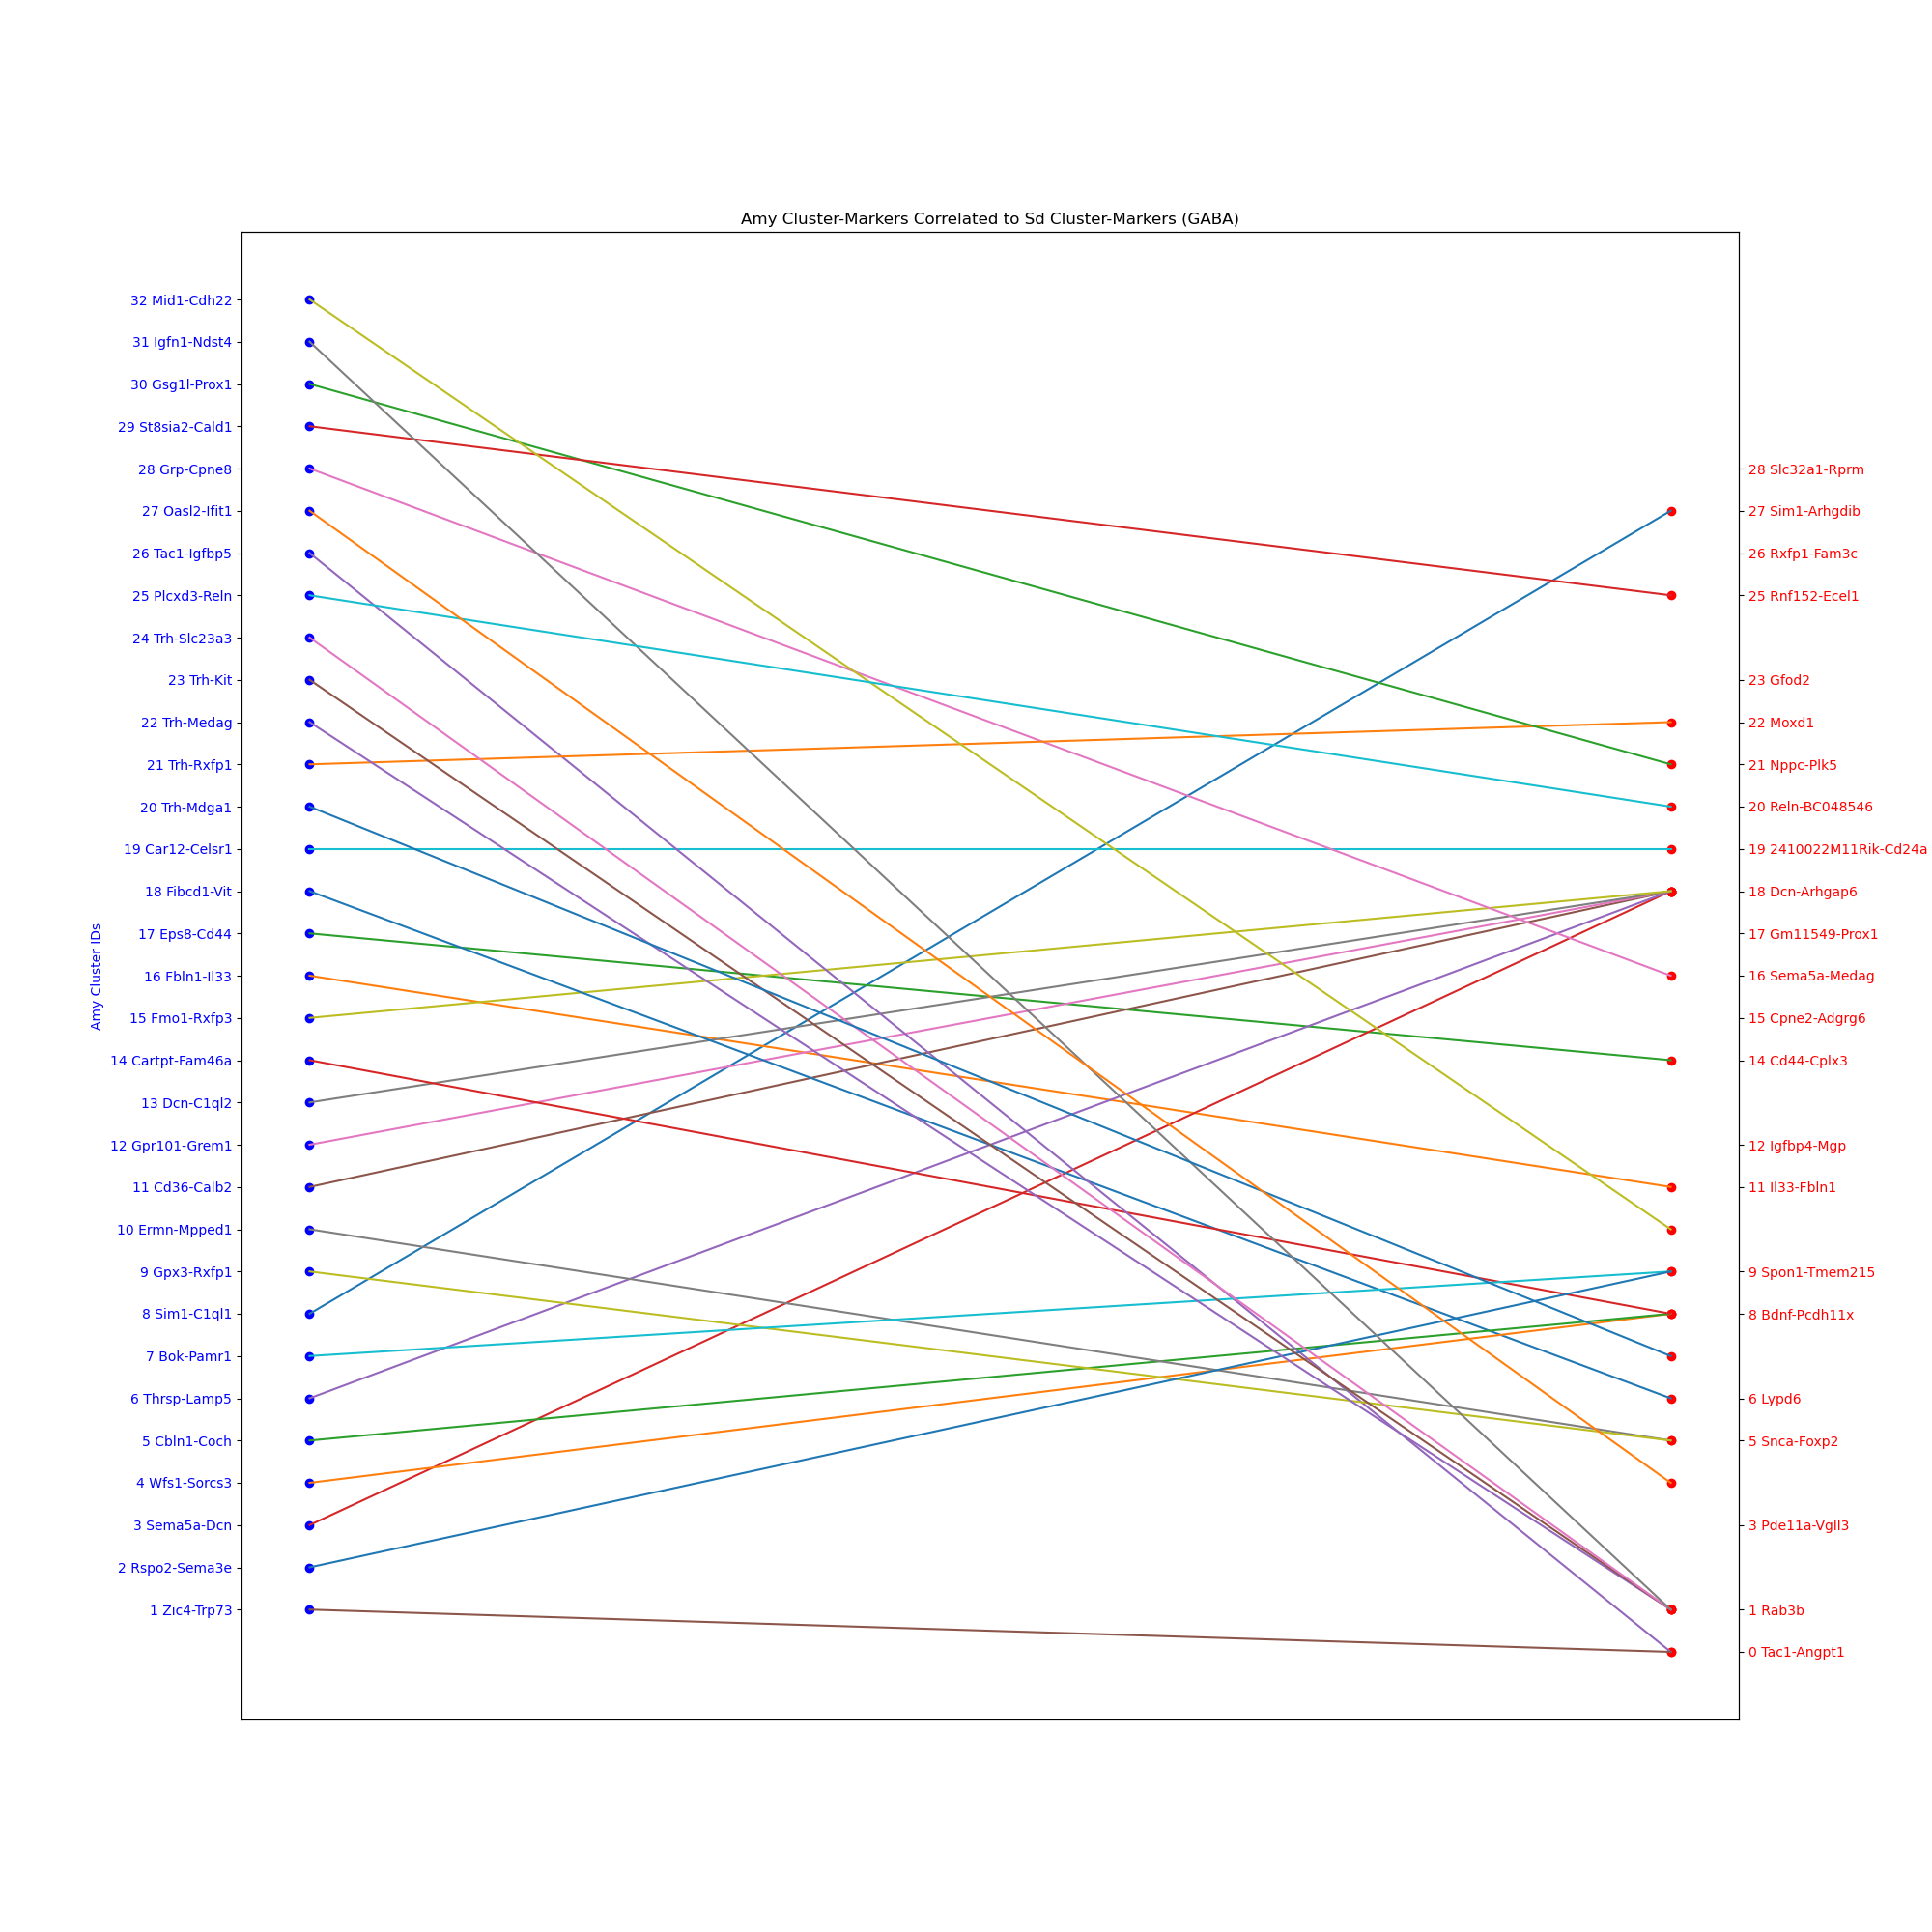

In [380]:
cc.plot_connector_plot_with_labels(connector_df_alt_lco_marker_shared_top,VGLUT1_mg_cl_dict_final_sorted,sd_labels,amy_labels, folder,'VGLUT1', savefig=True)

In [381]:
folder

'/bigdata/isaac/Vglut1_files/'

In [385]:
corr_matrix_manual_alt_lco_sorted.shape

(32, 29)

In [386]:
cc.plot_correlation_w_labels(corr_matrix_manual_alt_lco_sorted,sd_labels_df,amy_labels_df, folder, 'VGLUT1',savefig=True)

Launching server at http://localhost:34657


:HeatMap   [columns,index]   (value)

In [ ]:
##update corr plot with dropped/merged clusters (from dimorph_processing.py)

In [390]:
#from dp heatmap analysis 
clusters_to_drop = [28, 13, 24, 10, 2, 4, 7]

In [391]:
sd_labels_df_filtered_merged = sd_labels_df[~sd_labels_df['lco_index'].isin(clusters_to_drop)]

In [392]:
sd_labels_df_filtered_merged.shape

(22, 3)

In [393]:
corr_matrix_manual_alt_lco_sorted_filtered_merged = corr_matrix_manual_alt_lco_sorted.drop(columns = clusters_to_drop)

In [394]:
corr_matrix_manual_alt_lco_sorted_filtered_merged.shape

(32, 22)

In [315]:
folder

'/bigdata/isaac/gaba_files/'

In [395]:
cc.plot_correlation_w_labels(corr_matrix_manual_alt_lco_sorted_filtered_merged,sd_labels_df_filtered_merged,amy_labels_df, folder, 'VGLUT1_filtered_merged',savefig=True)

Launching server at http://localhost:36921


:HeatMap   [columns,index]   (value)

In [ ]:
#write labels df's to file

In [396]:
folder

'/bigdata/isaac/Vglut1_files/'

In [399]:
today

'2024-08-24'

In [400]:
sd_labels_df.to_csv(folder + 'VGLUT1_sd_labels_df_' + today + '.csv')

In [401]:
amy_labels_df.to_csv(folder + 'VGLUT1_amy_labels_df_' + today + '.csv')

In [402]:
sd_labels_df_filtered_merged.shape

(22, 3)

In [ ]:
###################old/backup/scratch###################

In [ ]:
tips = sns.load_dataset("tips") 

In [ ]:
tips

In [ ]:
fig,ax = plt.subplots()
sns.stripplot(x="day", y="total_bill", data=tips, jitter = 0.1)
plt.show()

### corrwith() vs. corr() example

In [ ]:
np.random.seed(5)
index = ["g1", "g2", "g3", "g4", "g5"]
columns = ["one", "two", "three", "four","five"]
df1 = pd.DataFrame(np.random.rand(5,5), index=index, columns=columns)
df2 = pd.DataFrame(np.random.rand(5,4), index=index, columns=columns[:4])


In [ ]:
df1

In [ ]:
df2

In [ ]:
df1.corrwith(df2, axis=0)

In [ ]:
pd.concat([df1, df2],axis=1).corr()

In [ ]:

# Initialize an empty dataframe to hold the correlation coefficients
correlation_matrix_chat = pd.DataFrame(index=df1.columns, columns=df2.columns)

# Compute the correlation coefficients
for col1 in df1.columns:
    for col2 in df2.columns:
        correlation_matrix_chat.loc[col1, col2] = df1[col1].corr(df2[col2])

In [ ]:
correlation_matrix_chat

In [ ]:
np.random.rand(4,4)

In [ ]:
sd_avgs.columns

2024-06-07 gaba_cl_mg_dict is missing a few clusters for some reason, reran on 2024-06-27

In [ ]:

#with open('/bigdata/isaac/gaba_files/gaba_cl_mg_dict2024-06-07.json') as json_data:
    #gaba_cl_mg_dict = json.load(json_data)

In [ ]:
sorted(gaba_cl_mg_dict.items())

In [ ]:
gaba_cl_mg_dict['31']

In [ ]:
gaba_df_marker_log_and_std.index[:18]

In [ ]:
gaba_df_marker_log_and_std.shape

In [ ]:
gaba_df_marker

In [ ]:
gaba_meta_data_df_plis

In [ ]:
gaba_mean_marker_per_cluster = pd.DataFrame(columns=['gene', 'avg_expr','cluster_id'])
for k,v in gaba_cl_mg_dict.items():
    #print (k,v)
    tmp_df = pd.DataFrame({'gene':gaba_cl_mg_dict[k],
                           'avg_expr':np.array(gaba_df_marker.loc[gaba_cl_mg_dict[k],gaba_df_marker.iloc[:,np.where(gaba_meta_data_df_plis.loc['cluster_label']==int(k))[0]].columns].mean(axis=1)), 
                           'cluster_id':np.array(int(k)*np.ones(len(gaba_cl_mg_dict[k])))})
    gaba_mean_marker_per_cluster = pd.concat([gaba_mean_marker_per_cluster, tmp_df])

gaba_mean_marker_per_cluster

In [ ]:
np.where(gaba_meta_data_df_plis.loc['cluster_label']==31)[0]

In [ ]:
gaba_cl_mg_dict['63']

In [ ]:
def compute_class_marker_mean(df,meta_data_df,cl_mg_dict):
    '''
    For level 2 analysis. Computes average expression of each marker gene for a specific cell class (e.g. gaba)                  
    ----------------------------------------------------------------------
    Parameters

    df: pandas.core.frame.DataFrame
        marker gene expression dataframe of a single cell class
    meta_data_df: pandas.core.frame.DataFrame
        gene expression metadata corresponding to df
    cl_mg_dict: pandas.core.frame.DataFrame
        2D input array, typically output from tsne, in dataframe format
    ----------------------------------------------------------------------
    Returns
    mean_marker_per_cluster: pandas.core.frame.DataFrame
        dataframe storing marker gene, avg expression, and cluster ID
    '''
    mean_marker_per_cluster = pd.DataFrame(columns=['gene', 'avg_expr','cluster_id'])
    for k,v in cl_mg_dict.items():
        #print (k,v)
        tmp_df = pd.DataFrame({'gene':cl_mg_dict[k],
                               'avg_expr':np.array(df.loc[cl_mg_dict[k],df.iloc[:,np.where(meta_data_df.loc['cluster_label']==int(k))[0]].columns].mean(axis=1)), 
                               'cluster_id':np.array(int(k)*np.ones(len(cl_mg_dict[k])))})
        
        #print (tmp_df.head())
        mean_marker_per_cluster = pd.concat([mean_marker_per_cluster, tmp_df])

    return mean_marker_per_cluster 

In [ ]:
gaba_mean_marker_per_cluster = compute_class_marker_mean(gaba_df_marker, gaba_meta_data_df_plis, gaba_cl_mg_dict)

In [ ]:
gaba_mean_marker_per_cluster